# ML- Predicción de Fuga de Clientes Bancarios

## Consideraciones del proyecto

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su **tasa de cancelación de clientes**. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

Este conjunto de datos contiene información sobre **clientes de una empresa de telecomunicaciones** y está distribuido en **cuatro tablas relacionadas** por `customerID`:

**1. Contract (7,043 registros):**
Información contractual y de facturación: fechas de inicio y fin del contrato, tipo de contrato (mensual, anual, bianual), método de pago, facturación sin papel, y cargos mensuales y totales.

**2. Personal (7,043 registros):**
Datos demográficos del cliente: género, si es adulto mayor, si tiene pareja y si tiene dependientes.

**3. Phone (6,361 registros):**
Información del servicio telefónico: si el cliente tiene múltiples líneas telefónicas.

**4. Internet (5,517 registros):**
Detalles del servicio de internet: tipo de conexión (DSL o fibra óptica) y servicios adicionales contratados (seguridad online, respaldo online, protección de dispositivos, soporte técnico, streaming de TV y películas).

La diferencia en el número de registros entre tablas sugiere que no todos los clientes tienen contratados todos los servicios (teléfono e internet).

Característica objetivo: la columna `'EndDate'` es igual a `'No'`.
* Métrica principal: AUC-ROC. 
* Métrica adicional: exactitud. 
* Criterios de evaluación:
- AUC-ROC < 0.75 — 0 SP
- 0.75 ≤ AUC-ROC < 0.81 — 4 SP
- 0.81 ≤ AUC-ROC < 0.85 — 4.5 SP
- 0.85 ≤ AUC-ROC < 0.87 — 5 SP
- 0.87 ≤ AUC-ROC < 0.88 — 5.5 SP
- AUC-ROC ≥ 0.88 — 6 SP

**IMPORTACIÓN DE LIBERÍAS**

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import os
import joblib
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
import pycaret.classification as pc
from pycaret.classification import compare_models
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

**PREPROCESAMIENTO**


=== Análisis inicial para: contract ===

Dimensiones del DataFrame:
(7043, 8)

Primeras filas:


,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65



Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           1869 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 440.3+ KB


None


Estadísticas descriptivas:


,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges
count,7043,7043,1869,7043,7043,7043,7043.000000,7043
unique,7043,NaN,NaN,3,2,4,NaN,6531
top,7590-VHVEG,NaN,NaN,Month-to-month,Yes,Electronic check,NaN,
freq,1,NaN,NaN,3875,4171,2365,NaN,11
mean,NaN,2017-04-30 13:01:50.918642688,2019-11-15 21:31:18.009630976,NaN,NaN,NaN,64.761692,NaN
min,NaN,2013-10-01 00:00:00,2019-10-01 00:00:00,NaN,NaN,NaN,18.250000,NaN
25%,NaN,2015-06-01 00:00:00,2019-11-01 00:00:00,NaN,NaN,NaN,35.500000,NaN
50%,NaN,2017-09-01 00:00:00,2019-11-01 00:00:00,NaN,NaN,NaN,70.350000,NaN
75%,NaN,2019-04-01 00:00:00,2019-12-01 00:00:00,NaN,NaN,NaN,89.850000,NaN
max,NaN,2020-02-01 00:00:00,2020-01-01 00:00:00,NaN,NaN,NaN,118.750000,NaN


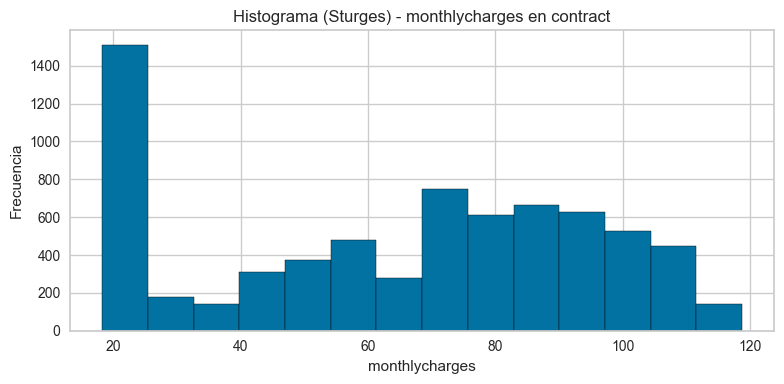

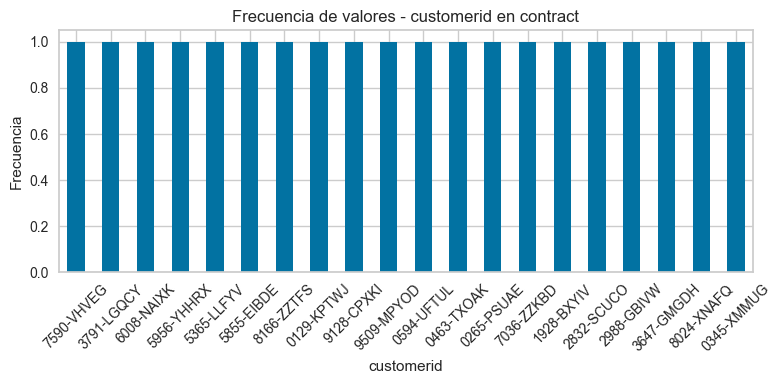

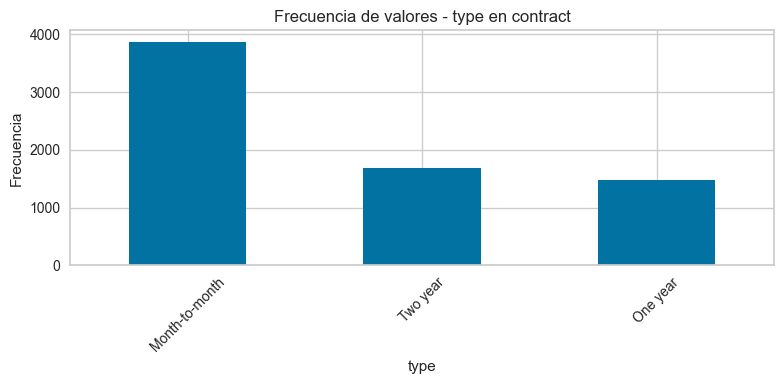

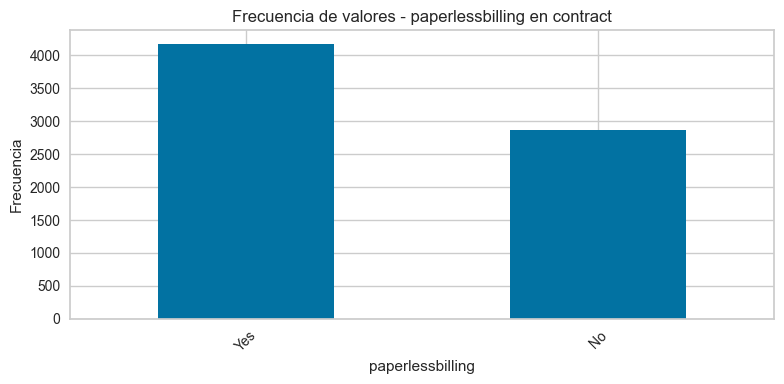

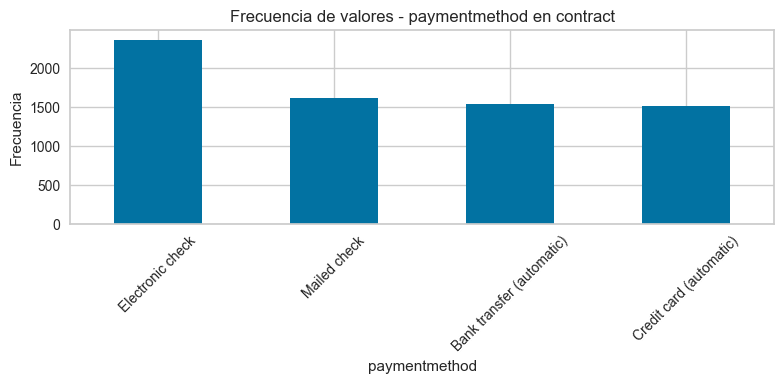

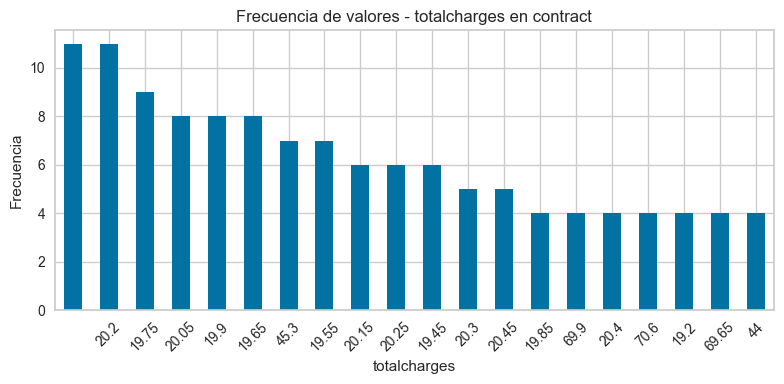


=== Análisis inicial para: internet ===

Dimensiones del DataFrame:
(5517, 8)

Primeras filas:


,customerid,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerid        5517 non-null   object
 1   internetservice   5517 non-null   object
 2   onlinesecurity    5517 non-null   object
 3   onlinebackup      5517 non-null   object
 4   deviceprotection  5517 non-null   object
 5   techsupport       5517 non-null   object
 6   streamingtv       5517 non-null   object
 7   streamingmovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None


Estadísticas descriptivas:


,customerid,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


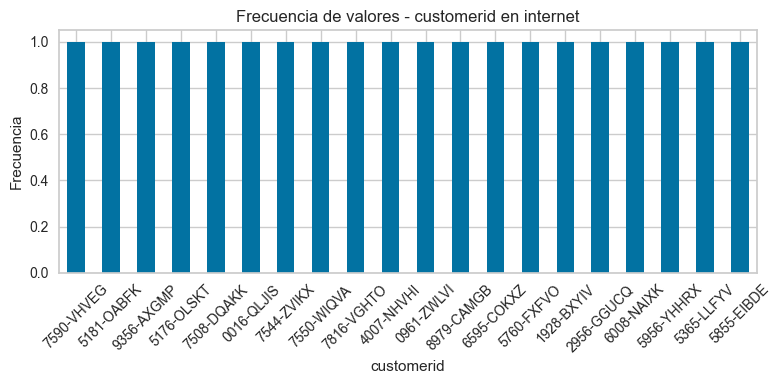

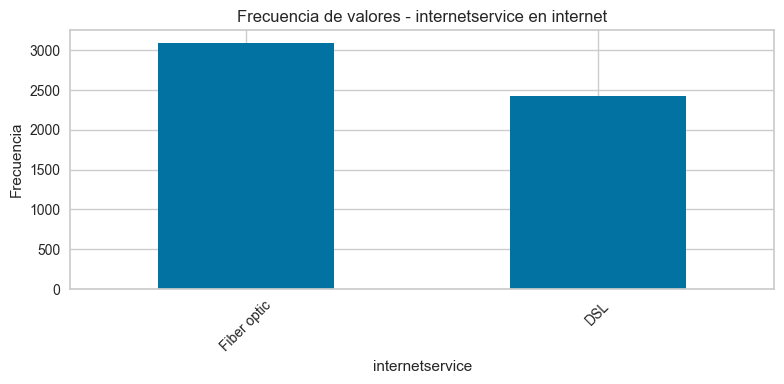

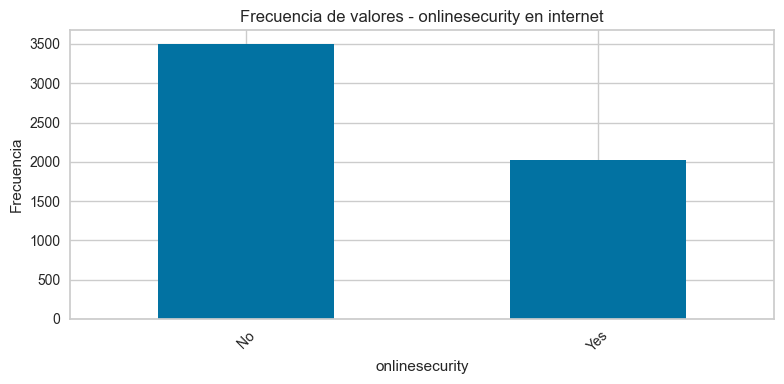

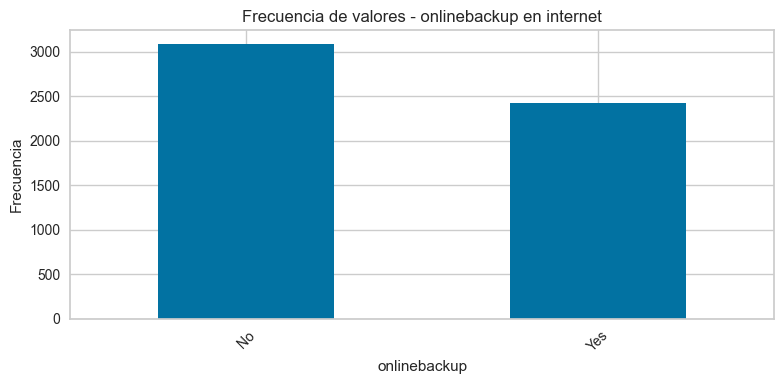

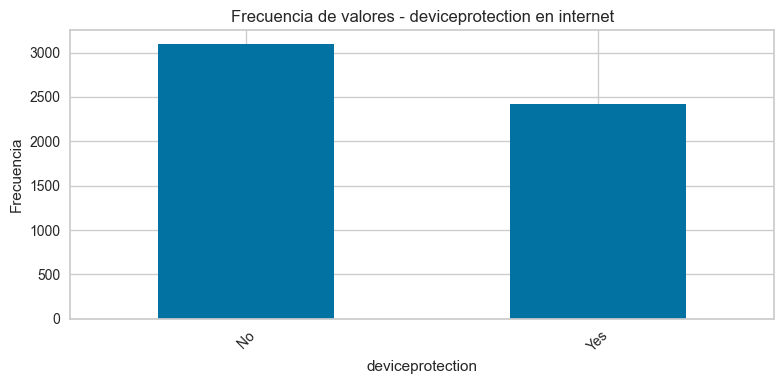

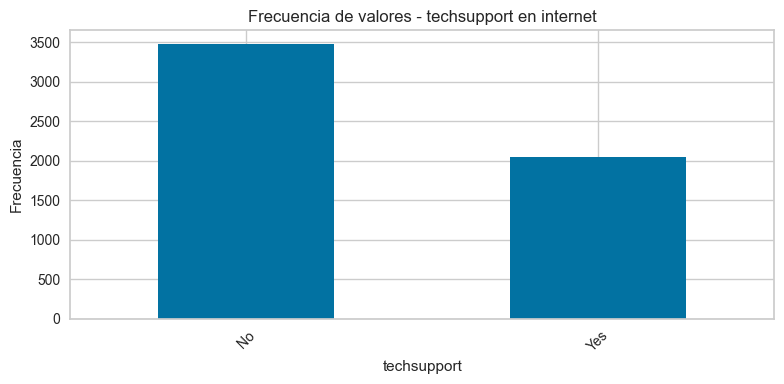

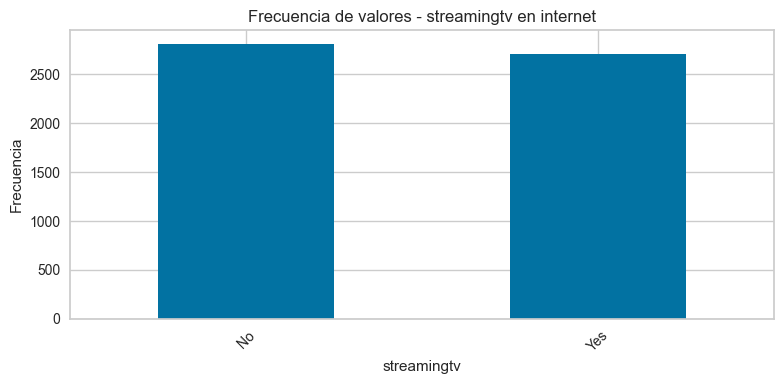

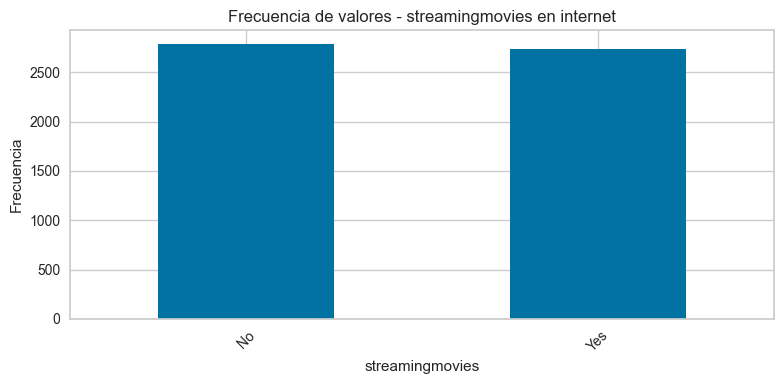


=== Análisis inicial para: personal ===

Dimensiones del DataFrame:
(7043, 5)

Primeras filas:


,customerid,gender,seniorcitizen,partner,dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     7043 non-null   object
 1   gender         7043 non-null   object
 2   seniorcitizen  7043 non-null   int64 
 3   partner        7043 non-null   object
 4   dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None


Estadísticas descriptivas:


,customerid,gender,seniorcitizen,partner,dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,7590-VHVEG,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


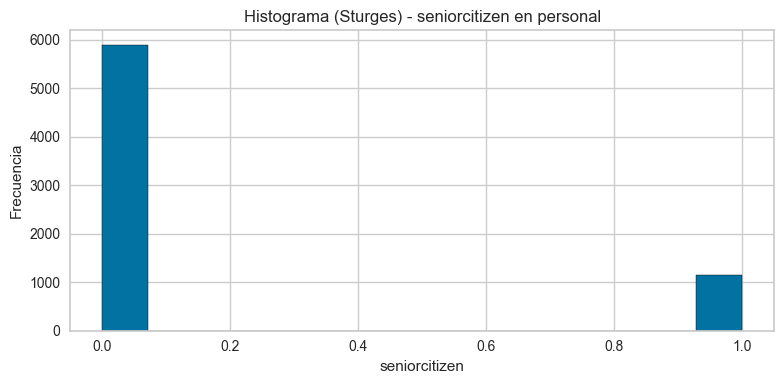

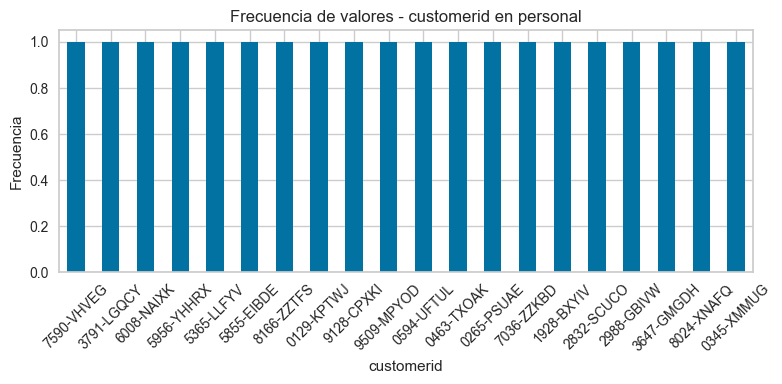

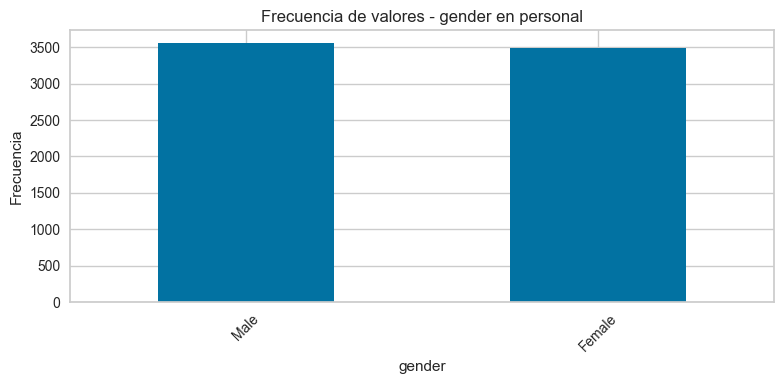

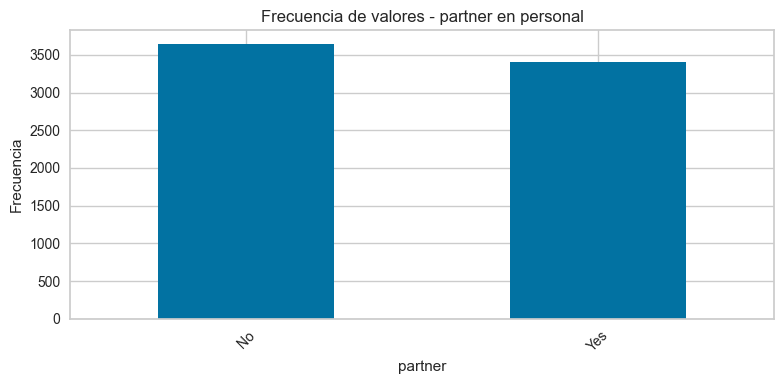

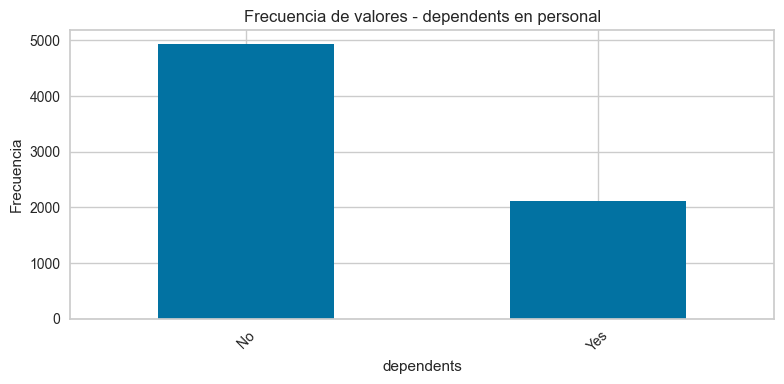


=== Análisis inicial para: phone ===

Dimensiones del DataFrame:
(6361, 2)

Primeras filas:


,customerid,multiplelines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     6361 non-null   object
 1   multiplelines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None


Estadísticas descriptivas:


,customerid,multiplelines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


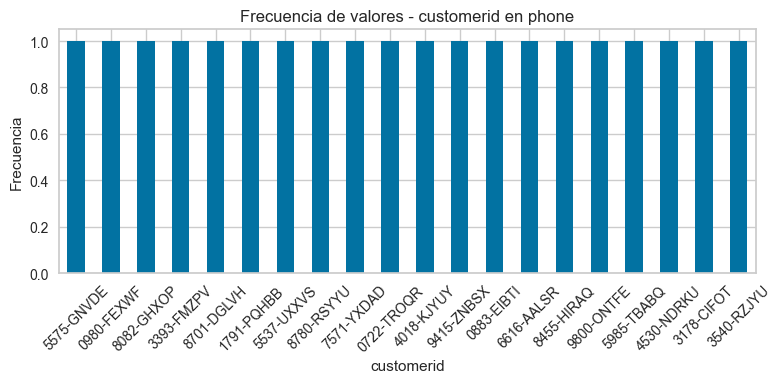

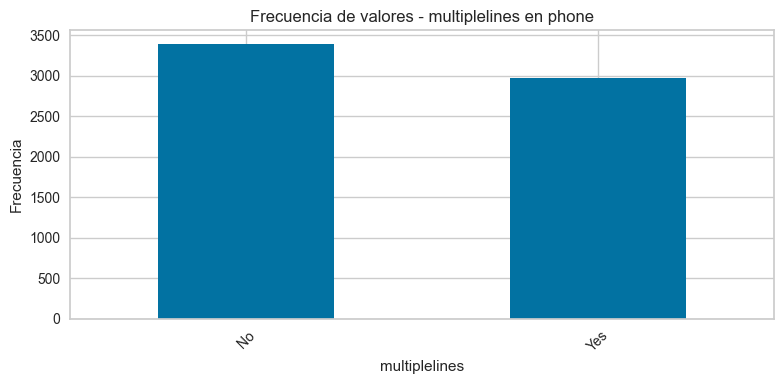

In [2]:
# Ruta donde se encuentran los archivos CSV
ruta = os.getcwd()

# Obtener todos los archivos CSV de la carpeta
archivos_csv = [archivo for archivo in os.listdir(ruta) if archivo.endswith('.csv')]

# Diccionario para almacenar los DataFrames
dataframes = {}

# Función para análisis de columnas numéricas
def analizar_columnas_numericas(df, nombre):
    columnas_numericas = df.select_dtypes(include='number').columns
    for col in columnas_numericas:
        datos = df[col].dropna()
        if len(datos) > 0:
            bins = int(np.ceil(np.log2(len(datos))) + 1)  # Regla de Sturges
            plt.figure(figsize=(8, 4))
            plt.hist(datos, bins=bins, edgecolor='black')
            plt.title(f'Histograma (Sturges) - {col} en {nombre}')
            plt.xlabel(col)
            plt.ylabel('Frecuencia')
            plt.grid(True)
            plt.tight_layout()
            plt.show()

# Función para análisis de columnas categóricas
def analizar_columnas_categoricas(df, nombre):
    columnas_categoricas = df.select_dtypes(include='object').columns
    for col in columnas_categoricas:
        conteo = df[col].value_counts().head(20)
        if not conteo.empty:
            plt.figure(figsize=(8, 4))
            conteo.plot(kind='bar')
            plt.title(f'Frecuencia de valores - {col} en {nombre}')
            plt.ylabel('Frecuencia')
            plt.xlabel(col)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

# Convertir las columnas a fecha. Ya que están como object
date_cols_by_table = {
    'contract' : ['BeginDate', 'EndDate'],
    'personal' : [],
    'internet' : [],
    'phone' : []
}

# Cargar los archivos CSV y mostrar análisis preliminar
for archivo in archivos_csv:
    nombre_base = archivo.replace('.csv', '')
    df = pd.read_csv(os.path.join(ruta, archivo))
    
    # Hacer snakecase los nombres de las columnas
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    dataframes[nombre_base] = df

    # Convertir columnas a tipo fecha si es necesario
    if nombre_base == 'contract':
        for col in ['begindate', 'enddate']:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    print(f'\n=== Análisis inicial para: {nombre_base} ===')

    print('\nDimensiones del DataFrame:')
    print(df.shape)

    print('\nPrimeras filas:')
    display(df.head())

    print('\nInformación general:')
    display(df.info())

    print('\nEstadísticas descriptivas:')
    display(df.describe(include='all'))

    # Análisis según tipo de columna
    analizar_columnas_numericas(df, nombre_base)

    analizar_columnas_categoricas(df, nombre_base)

**Se modificó el bloque de código, para que:**

* Se pudieran leer los archivos desde una ruta local, ya que, se trabajará de manera local.
* Se hace un snakecase del nombre de las columnas (sin mayúsculas o espacios o caracteres separadores)
* Se muestra el shape() de cada DataFrame
* Se convierte en contract, las fechas a formato fecha.

**Observaciones para 'contract':**

El método info muestra información valiosa, hay dos columnas en las que existen problemas (['enddate'] y sus nulos y ['totalcharges'] en su tipo).


* Se concluyó que los valores nulos de enddate son clientes que todavía no han terminado el contrato, no nulos reales.
* Todas las contrataciones y las féchas de término de contrato, pasan hasta la madrugada del día corriente.
* La mayoría de los clientes tiene un contrato de mes a mes, tienen casi la misma proporción los anuales, los bianuales siendo un poco más representativos.
* La gran mayoría de los clientes prefieren sus cuentas en otro método que no sea papel.
* La tendencia es que los clientes paguen de manera electrónica, seguido de una proporción casi igual para los que pagan por correo, por transferencia bancaria (automatizado) y con tarjeta (automatizado) respectivamente.
* Por cliente, en promedio, se han realizado 64.76 (+/- 30) cobros mensuales. Con un mínimo de 18, una mediana de 70 y un máximo de 118 meses cobrados a un cliente.
* Para la columna totalcharges, se encontraron 11 valores que correspondían a celdas con valor ''. Por su pocoo peso, se asignaron a valores NaN y para mantener la integridad y la conexión de las tablas, se reemplazaron por la mediana. Los valores mínimos y máximos son muy diferentes, hay una media de 2282 y una mediana de 1397.47 para esta columna.
* Se corrobora lo que se muestra en con el método info(). No existen nulos ni valores duplicados para el resto de las columnas. Ni duplicados explícitos duplicated o implícitos value_counts -->

In [3]:
df_contract = dataframes['contract']
# Valores duplicados
contract_d = df_contract['enddate'].duplicated().sum()
# Valores nulos
contract_n = df_contract['enddate'].isnull().sum()
# Valores únicos
contract_u = df_contract['enddate'].nunique()

print(f'Los valores duplicados son {contract_d}')
print(f'Los valores nulos son {contract_n}')
print(f'Los valores únicos son {contract_u}')

# Con esto nos damos cuenta que hay 4 valores únicos + los nulos
display(df_contract.value_counts('enddate'))
contract_val = df_contract['enddate'].value_counts().sum()
# Conclusión de nulos
print(f'La suma de los valores únicos de la fecha de término es {contract_val}')
print(f'Esta suma con los valores nulos corresponden a {contract_n + contract_val}, lo que nos dice que los nulos son aquellos contratos que no han terminado aún.')

display(df_contract.duplicated().sum())
display(df_contract.isnull().sum())

df_contract['type'].value_counts()
df_contract['paperlessbilling'].value_counts()
df_contract['paymentmethod'].value_counts()
df_contract['monthlycharges'].describe()

# Correción de totalcharges, tenía espacios en blanco que son nulos
df_contract['totalcharges'].value_counts().sort_index()
df_contract['totalcharges'] = df_contract['totalcharges'].replace(' ', np.nan)
df_contract['totalcharges'] = pd.to_numeric(df_contract['totalcharges'], errors='coerce')
# Rellenar NaN con la mediana y convertir a float, únicamente son 11 valores nulos
df_contract['totalcharges'].fillna(df_contract['totalcharges'].median(), inplace=True)
df_contract['totalcharges'] = df_contract['totalcharges'].astype(float)
df_contract['totalcharges'].describe()

# Ahora que se modificó df_contract, actualizamos el diccionario
dataframes['contract'] = df_contract

Los valores duplicados son 7038
Los valores nulos son 5174
Los valores únicos son 4


enddate
2019-11-01    485
2019-12-01    466
2020-01-01    460
2019-10-01    458
Name: count, dtype: int64

La suma de los valores únicos de la fecha de término es 1869
Esta suma con los valores nulos corresponden a 7043, lo que nos dice que los nulos son aquellos contratos que no han terminado aún.


0

customerid             0
begindate              0
enddate             5174
type                   0
paperlessbilling       0
paymentmethod          0
monthlycharges         0
totalcharges           0
dtype: int64

**Observaciones para 'internet':**



* Inicialmente esta tabla cuenta con 5517 entradas, y ninguna de las columnas tiene valores nulos. Habrá que estudiarla más a fondo. 
* Usando un value_counts() para cada columna puedo asegurarme que no hay valores implícitos que pudieran repetirse, o valores nulos enmcascarados.
* Con el método head() me serioro, que, excluyendo la columna de customerid, ['internetservice'] contiene datos categóricos (2 categorías) y que todas las demás contienen respuestas categóricas que se definen en Sí/No (Adecuado para su futura codificación).
* También, todos los ids registrados, se encuentran en la tabla del contrato (prueba de integridad).
* Hacer un .describe() en esta tabla, por ejemplo, sería una pérdida de tiempo, por el tipo de dato.

En cuanto a su comportamiento veo que:
* La mayoría de los usuarios que tienen un paquete de internet, tienen fibra óptica, sin embargo, la proporción no es tan diferente siendo un 56 vs 44 %.
* El 63% de los usuarios tiene seguridad en línea, contra un 36%.
* El 55% de los usaurios no posee un respaldo de su información en línea, contra un 44% que sí lo tiene.
* Irónicamente, a pesar de que la mayoría cuenta con seguridad en línea, el 56% de los usuarios no tiene protección para su dispositivo, contra un 44% que sí lo tiene, uno pensaría que los dispositivos son más vulnerables ante todo!.
* El 63% de los usuarios no tiene contratado el soporte ténico en su paquete, mientras el 37% sí lo tiene.
* Conjunto a su paquete de internet, existe un 50% de los usuarios que no tienen un servicio de streaming, contra un 49, una proporción casi de la mitad. Esto aplica tanto para streaming de tv y de películas.

In [4]:
df_internet = dataframes['internet']
# Valores duplicados
d_df_internet = df_internet.duplicated().sum()
# Valores nulos
n_df_internet = df_internet.isnull().sum().sum()
# Valores únicos
u_df_internet = df_internet.nunique().sum()

print(f'Los valores duplicados son {d_df_internet}')
print(f' Los valores nulos son: {n_df_internet}')
print(f' Los valores únicos son: {u_df_internet}')

df_internet['customerid'].value_counts().sum() # Corresponde al número de filas
df_internet['internetservice'].value_counts() #normalize=True
df_internet['onlinesecurity'].value_counts() #normalize=True
df_internet['onlinebackup'].value_counts() #normalize=True
df_internet['deviceprotection'].value_counts() #normalize=True
df_internet['techsupport'].value_counts() #normalize=True
df_internet['streamingtv'].value_counts() #normalize=True
df_internet['streamingmovies'].value_counts() #normalize=True

# df_internet['existe_en_contract'] = df_internet['customerid'].isin(df_contract['customerid'])
# df_internet['existe_en_contract'].value_counts()
# df_internet = df_internet.drop(columns=['existe_en_contract']) # Ya que todos existen en contract

Los valores duplicados son 0
 Los valores nulos son: 0
 Los valores únicos son: 5531


streamingmovies
No     2785
Yes    2732
Name: count, dtype: int64

**Observaciones para 'personal':**

* Esta tabla cuenta con 7043 entradas, y en todas las columnas, parecen estar presentes. Habrá que verla un poco más a fondo.
* No existen duplicados explícitos, valores nulos y los valores únicos ascienden a 7051 lo que es coherente si además de id, el resto de columnas tienen dos valores.
* Como se predijo, el resto de las columnas corresponden a valores categóricos como el sexo (Male/Female), seniorcittizen (1/0) o parter/dependents (Sí/No).
* Todos los ids de esta tabla, se encuentran en la tabla de contract.

En cuanto a los datos:
* Todos los ids son únicos.
* Existe un balance casi perfecto (50% para hombres y 49% para mmujeres) en el sexo.
* La gran mayoría de los clientes, no son clientes mayores, únicamente el 16% lo son.
* Con un balance, casi perfecto, el 51% de los clientes no tienen pareja, mientras que, el 48% sí la tienen.
* Finalmente, el 70% de los clientes no cuentan con dependientes económicos, mientras que el 30% sí lo tienen.

In [5]:
# Seccionar el dataframe
df_personal = dataframes['personal']

# Valores diplicados
d_df_personal = df_personal.duplicated().sum()
# Valores nulos
n_df_personal = df_personal.isnull().sum().sum()
# Valores únicos
u_df_personal = df_personal.nunique().sum()

print(f'Los valores duplicados son {d_df_personal}')
print(f' Los valores nulos son: {n_df_personal}')
print(f' Los valores únicos son: {u_df_personal}')

df_personal['customerid'].value_counts().sum()
df_personal['gender'].value_counts() # normalize=True
df_personal['seniorcitizen'].value_counts() # normalize=True
df_personal['partner'].value_counts() # normalize=True
df_personal['dependents'].value_counts() # normalize=True

# # Comprobar si todos los customerid de personal están en contract
# df_personal['existe_en_contract'] = df_personal['customerid'].isin(df_contract['customerid'])
# df_personal['existe_en_contract'].value_counts() # 7043 True
# df_personal = df_personal.drop(columns=['existe_en_contract']) # Ya que todos existen en contract

Los valores duplicados son 0
 Los valores nulos son: 0
 Los valores únicos son: 7051


dependents
No     4933
Yes    2110
Name: count, dtype: int64

**Observaciones para 'phone':**

* Tiene únicamente dos columnas (se les hizo snakecase)
* Una de ellas es el ID del cliente, y la otra únicamente dice si tienen varias líneas (Si/No).
* No existen nu valores nulos ni duplicados (implícitos/explícitos).
* El ID contiene, afortunadamente, valores únicos, ya que customerid tiene 6361 valores únicos que corresponden al número de filas.

.
* EL 53% de los usuarios no poseen líneas múltiples, contra el 46% que sí las tiene.

In [6]:
df_phone = dataframes['phone']
# CustomerID, solo contiene valores únicos 
display(df_phone.nunique())
# No hay valores nulos, ni duplicados
display(df_phone.isnull().sum())
display(df_phone.duplicated().sum())

df_phone['customerid'].value_counts().sum() # Corresponde al número de filas
df_phone['multiplelines'].value_counts(normalize=True)

# # Comprobar si todos los customerid de phone están en contract
# df_phone['existe_en_contract'] = df_phone['customerid'].isin(df_contract['customerid'])
# df_phone['existe_en_contract'].value_counts() # 6361 True, 682 False
# df_phone = df_phone.drop(columns=['existe_en_contract']) # Ya que todos existen en contract

customerid       6361
multiplelines       2
dtype: int64

customerid       0
multiplelines    0
dtype: int64

0

multiplelines
No     0.532935
Yes    0.467065
Name: proportion, dtype: float64

Existe un problema. Hay muchos datos que no tienen fecha de término, y si eso de queda como muchos NaNs, a la hora del modelado, habrá muchos problemas y sesgos. Decidí hacer una columna que categorice si el usuario está activo o no, y su antiguedad basado en una fecha de corte.

In [7]:
# Feature engineering en contract

# Copia de la tabla bases
df_contract = dataframes['contract'].copy()

# Agregar máxima fecha 
max_beg = df_contract['begindate'].max()
max_end = df_contract['enddate'].max()
fecha_corte = max(max_beg, max_end) # Fecha de corte guía para el cálculo de tenure

# Categorizar en activos (1) e inactivos (0)
df_contract['contract_active'] = df_contract['enddate'].isna().astype(int)

# Calculo de antigüedad en días
df_contract['tenure'] = (fecha_corte - df_contract['begindate']).dt.days

# Prueba de cordura en fechas (tenure no negativo)
mascara = df_contract['tenure'] < 0
df_contract.loc[mascara, 'tenure'] = np.nan
display(mascara.sum())

0

Analizando el problema, el target o problema a predecir, este pertenece a un problema de clasificación, por lo que, usar la columna ['contract_active'] para el modelado, es básicamente hacer data leakage, por lo cual, es clave mencionar que en un paso posterior, esta columna debe omitirse.

In [8]:
# El target se crea a partir de contract_active, se crea 'y' y se quita de X
y = (df_contract['enddate'].notna()).astype(int) # 1=churn, 0=activo (EndDate=='No'/NaT)
df_contract['churn'] = y

# Limpieza de predictores que filtran el target
cols_leak = ['contract_active', 'enddate']  # enddate se usa para y, no como feature
df_contract = df_contract.drop(columns=[c for c in cols_leak if c in df_contract.columns])

# Ahora que se modificó df_contract, actualizamos el diccionario
dataframes['contract'] = df_contract

Se grafica tanto tenure como totalcharges para ver si existen valores aberranteas en estas categorías numéricas.

Número de anomalías:  0
Número de outliers detectados manualmente: 0


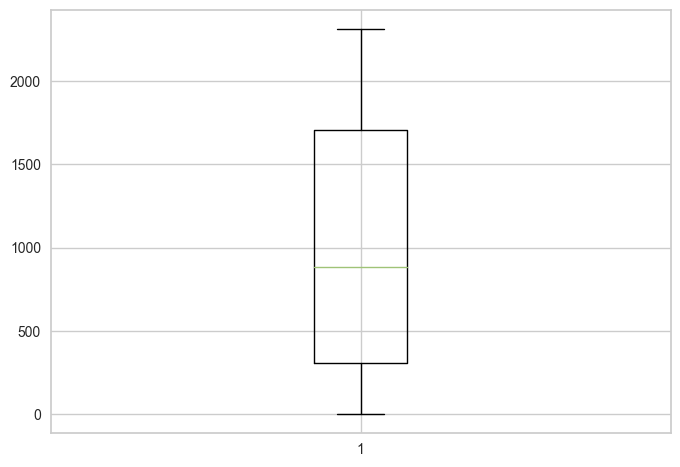

In [9]:
# Percentiles de tenure
tenure_d = df_contract['tenure'].dropna() 
Q1 = df_contract['tenure'].quantile(0.25) 
Q3 = df_contract['tenure'].quantile(0.75) 
IQR = Q3 - Q1 
lower_bound = Q1 - 1.5 * IQR 
upper_bound = Q3 + 1.5 * IQR 

boxplot = plt.boxplot(df_contract['tenure'].dropna().values) 
outliers = list(boxplot['fliers'][0].get_data()[1]) 

df_outliers = df_contract[df_contract['tenure'].isin(outliers)] 
print('Número de anomalías: ', len(df_outliers)) 

outliers = tenure_d[(tenure_d < lower_bound) | (tenure_d > upper_bound)] 
print(f"Número de outliers detectados manualmente: {len(outliers)}")

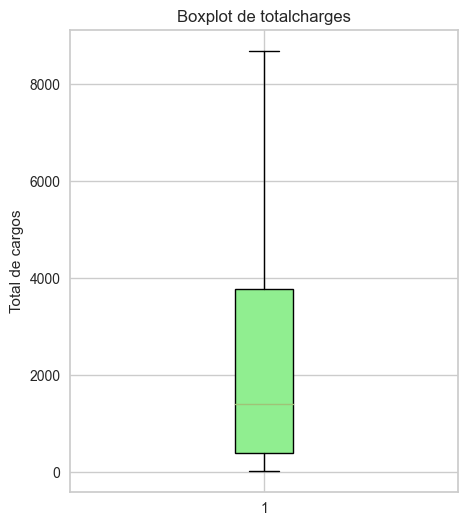

Outliers (Tukey) en totalcharges: 0


In [10]:
# Outliers para totalcharges
tc = df_contract['totalcharges']
tc_clean = tc.dropna()

Q1_tc = tc_clean.quantile(0.25)
Q3_tc = tc_clean.quantile(0.75)
IQR_tc = Q3_tc - Q1_tc
lower_bound_tc = Q1_tc - 1.5 * IQR_tc
upper_bound_tc = Q3_tc + 1.5 * IQR_tc

plt.figure(figsize=(5,6))
boxplot_tc = plt.boxplot(tc_clean.values, vert=True, patch_artist=True,
                         boxprops=dict(facecolor='lightgreen'))
plt.title('Boxplot de totalcharges')
plt.ylabel('Total de cargos')
plt.show()

outliers_tc = tc_clean[(tc_clean < lower_bound_tc) | (tc_clean > upper_bound_tc)]
print(f"Outliers (Tukey) en totalcharges: {len(outliers_tc)}")

No existen outliers en estos nuevos valores (tenure), ni en el cargo total de los clientes. A continuación, haré dos datasets con diferentes métodos de unión.

In [11]:
# Crear una copia del diccionario original
dataframes_original = dataframes.copy()

# AHora vamos a pasar a dataframe usamos contract como base
df_final = dataframes['contract'].copy()

# Hago un merge con personal --> internet --> phone. Todas están interneconectadas por customerid
df_final = df_final.merge(dataframes['personal'], on='customerid', how='left')
df_final = df_final.merge(dataframes['internet'], on='customerid', how='left', suffixes=('', '_internet'))
df_final_left = df_final.merge(dataframes['phone'], on='customerid', how='left', suffixes=('', '_phone'))

# Verifico que todo esté correcto
display(df_final_left.info())

# Merge con inner para quedarme solo con los que tienen teléfono e internet
df_final_inner = df_final.merge(dataframes['phone'], on='customerid', how='inner')
df_final_inner = df_final_inner.merge(dataframes['internet'], on='customerid', how='inner')

# Verifico que todo esté correcto
display(df_final_inner.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   type              7043 non-null   object        
 3   paperlessbilling  7043 non-null   object        
 4   paymentmethod     7043 non-null   object        
 5   monthlycharges    7043 non-null   float64       
 6   totalcharges      7043 non-null   float64       
 7   tenure            7043 non-null   float64       
 8   churn             7043 non-null   int32         
 9   gender            7043 non-null   object        
 10  seniorcitizen     7043 non-null   int64         
 11  partner           7043 non-null   object        
 12  dependents        7043 non-null   object        
 13  internetservice   5517 non-null   object        
 14  onlinesecurity    5517 n

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customerid          4835 non-null   object        
 1   begindate           4835 non-null   datetime64[ns]
 2   type                4835 non-null   object        
 3   paperlessbilling    4835 non-null   object        
 4   paymentmethod       4835 non-null   object        
 5   monthlycharges      4835 non-null   float64       
 6   totalcharges        4835 non-null   float64       
 7   tenure              4835 non-null   float64       
 8   churn               4835 non-null   int32         
 9   gender              4835 non-null   object        
 10  seniorcitizen       4835 non-null   int64         
 11  partner             4835 non-null   object        
 12  dependents          4835 non-null   object        
 13  internetservice_x   4835 non-null   object      

None

Existen inconsistencias con los nombres de las columnas, aparentemente algunas de ellas se duplicaron por lo que es necesario evaluar, si, en efecto los datos son repeticiones, y si es el caso, mantener solamente una columna.

In [12]:
# Se duplicaron columnas
son_iguales = (df_final_inner['internetservice_x'] == df_final_inner['internetservice_y']).all()
print(son_iguales) # Son iguales, se borra el duplicado

# Renombrar las columnas _x
cols_x = [col for col in df_final_inner.columns if col.endswith('_x')]
df_final_inner.rename(columns={col: col[:-2] for col in cols_x}, inplace=True)
# Remover columnas _y
cols_y = [col for col in df_final_inner.columns if col.endswith('_y')]
df_final_inner.drop(columns=cols_y, inplace=True)

df_final_inner.info()

True
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        4835 non-null   object        
 1   begindate         4835 non-null   datetime64[ns]
 2   type              4835 non-null   object        
 3   paperlessbilling  4835 non-null   object        
 4   paymentmethod     4835 non-null   object        
 5   monthlycharges    4835 non-null   float64       
 6   totalcharges      4835 non-null   float64       
 7   tenure            4835 non-null   float64       
 8   churn             4835 non-null   int32         
 9   gender            4835 non-null   object        
 10  seniorcitizen     4835 non-null   int64         
 11  partner           4835 non-null   object        
 12  dependents        4835 non-null   object        
 13  internetservice   4835 non-null   object        
 14  onlinesecurity    4

Una vez hecho esto, se hace una matriz de correlación con sus gráficas de calor para las variables numéricas en los diferentes joins para ver su comportamiento.

                monthlycharges  totalcharges    tenure     churn  \
monthlycharges        1.000000      0.623158  0.452315  0.018891   
totalcharges          0.623158      1.000000  0.958450 -0.342113   
tenure                0.452315      0.958450  1.000000 -0.358986   
churn                 0.018891     -0.342113 -0.358986  1.000000   
seniorcitizen         0.143692      0.031623  0.006555  0.113235   

                seniorcitizen  
monthlycharges       0.143692  
totalcharges         0.031623  
tenure               0.006555  
churn                0.113235  
seniorcitizen        1.000000  


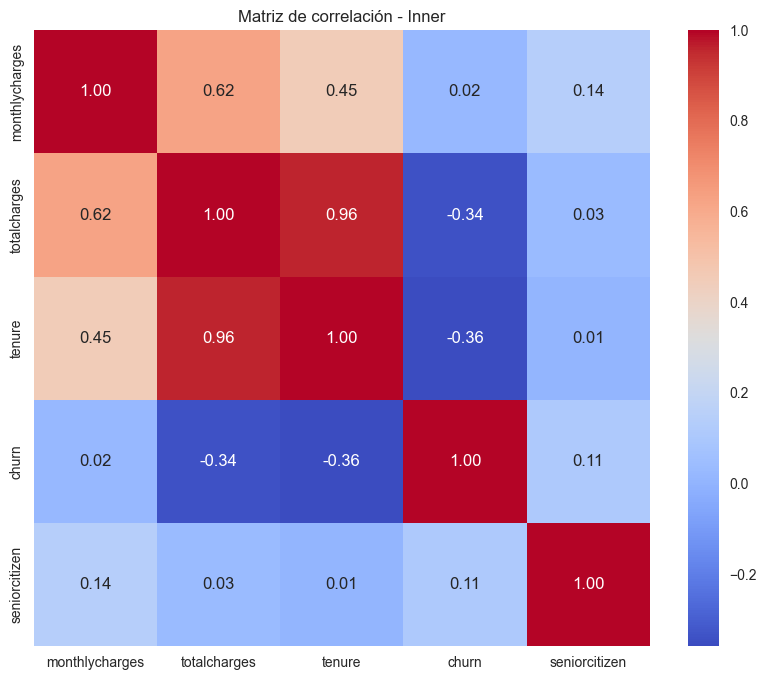

                monthlycharges  totalcharges    tenure     churn  \
monthlycharges        1.000000      0.650864  0.260860  0.193356   
totalcharges          0.650864      1.000000  0.828659 -0.199037   
tenure                0.260860      0.828659  1.000000 -0.311715   
churn                 0.193356     -0.199037 -0.311715  1.000000   
seniorcitizen         0.220173      0.102652  0.023454  0.150889   

                seniorcitizen  
monthlycharges       0.220173  
totalcharges         0.102652  
tenure               0.023454  
churn                0.150889  
seniorcitizen        1.000000  


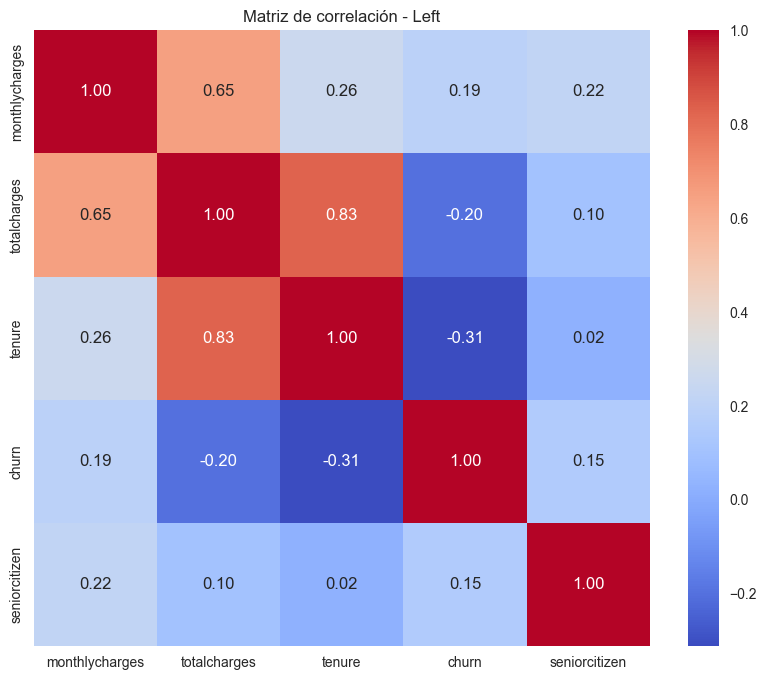

In [13]:
# Matriz de correlación para variables numéricas de inner
corr_inner = df_final_inner.corr(numeric_only=True)
print(corr_inner)
# Mostrar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_inner, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de correlación - Inner")
plt.show()

# Matriz de correlación para variables numéricas de left
corr_left = df_final_left.corr(numeric_only=True)
print(corr_left)
# Mostrar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_left, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de correlación - Left")
plt.show()

# Graficar una contra la otra

Con estos resultados puedo evidenciar dos cosas:
* Cuando se hace la matriz de correlación con en el inner, se pierden muchísimos datos.
* Dada esta pérdida de datos, cuando se hace una matriz de correlación, nuestra feature hecha (['tenure']) tiene una correlación altísima con ['totalcharges'], siendo DataLeakage/Habiendo mmulticolinealidad (todavía no conozco el target, entonces no sé a cual corresponde).

Por lo que, para el modelado, se utilizará el joint que usó la estrategia left.

Después de ver este comportamiento, se hace el preprocesamiento en el dataset correspondiente. También sabemos que los NaNs de df_final_left no son nulos reales, sino nulos estructurales creados por el método de unión. Son de clientes que sí aparecen en df[contract] pero que no poseen servicios de internet o teléfono, entnonces están ausentes en df['internet]/df['phone']. Lo más coherente, es convertir estos faltantes estructurales en categorías explícitas para rellenar estos espacios y evitar un data leakage.

**FEATURE ENGINEERING** Ya que decidí usar el merge de left, se hará un feature engineering.

* Creación de una columna que obedecen a clientes con o sin internet (has_internet).
* De la misma manera, una columna que obedecen a clientes con o sin teléfono (has_phone).
* Se hará una categoría binaria para la columna ['tenure'] para tratar de clasificar a los clientes como clientes con contratos largos o clientes con contratos cortos.
* Se hará una categoría binaria para la columna ['paymentmethod'] para clasificar a las personas que, realizan sus pagos de manera automática y a los que no. (Bank transfer + Credit Card)

In [14]:
# Hacer una copia del dataframe left para hacer feature engineering
df_final_left = df_final_left.copy()
# Creacion de categoria has internet
df_final_left['has_internet'] = df_final_left['internetservice'].notna().astype(int)
# Creacion de categoria has phone
df_final_left['has_phone'] = df_final_left['multiplelines'].notna().astype(int)

# Listado de columas
internet_cols = ['internetservice', 'onlinesecurity', 'onlinebackup',
    'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies']
phone_cols = ['multiplelines']

# Rellenar has phone
df_final_left.loc[df_final_left['has_phone'] == 0, 'multiplelines'] = 'NoPhone'
# Rellenar has internet
df_final_left.loc[df_final_left['has_internet'] == 0, internet_cols] = 'NoInternet'
for col in internet_cols[1:]: # Evitar la primera columna que es internetservice
    df_final_left.loc[df_final_left['has_internet'] == 0, col] = 'NoInternet' # Rellenar las otras columnas de internet

# Categorizar tenure
df_final_left['tenure'].describe() # Está en días, 1706 
df_final_left['long_tenure'] = (df_final_left['tenure'] >= 1706).astype(int) # 1= largo, 0= corto, escogo percentil 75 como 'alto'
display(df_final_left['long_tenure'].value_counts(normalize=True).sort_index())

# Categorizar paymentmethod
df_final_left['automatic_payment'] = df_final_left['paymentmethod'].isin(['Bank transfer (automatic)', 'Credit card (automatic)']).astype(int) # 1= automático, 0= no automático
display(df_final_left['automatic_payment'].value_counts(normalize=True).sort_index())

# Verificación (info)
df_final_left.info()

long_tenure
0    0.746273
1    0.253727
Name: proportion, dtype: float64

automatic_payment
0    0.564674
1    0.435326
Name: proportion, dtype: float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customerid         7043 non-null   object        
 1   begindate          7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperlessbilling   7043 non-null   object        
 4   paymentmethod      7043 non-null   object        
 5   monthlycharges     7043 non-null   float64       
 6   totalcharges       7043 non-null   float64       
 7   tenure             7043 non-null   float64       
 8   churn              7043 non-null   int32         
 9   gender             7043 non-null   object        
 10  seniorcitizen      7043 non-null   int64         
 11  partner            7043 non-null   object        
 12  dependents         7043 non-null   object        
 13  internetservice    7043 non-null   object        
 14  onlinese

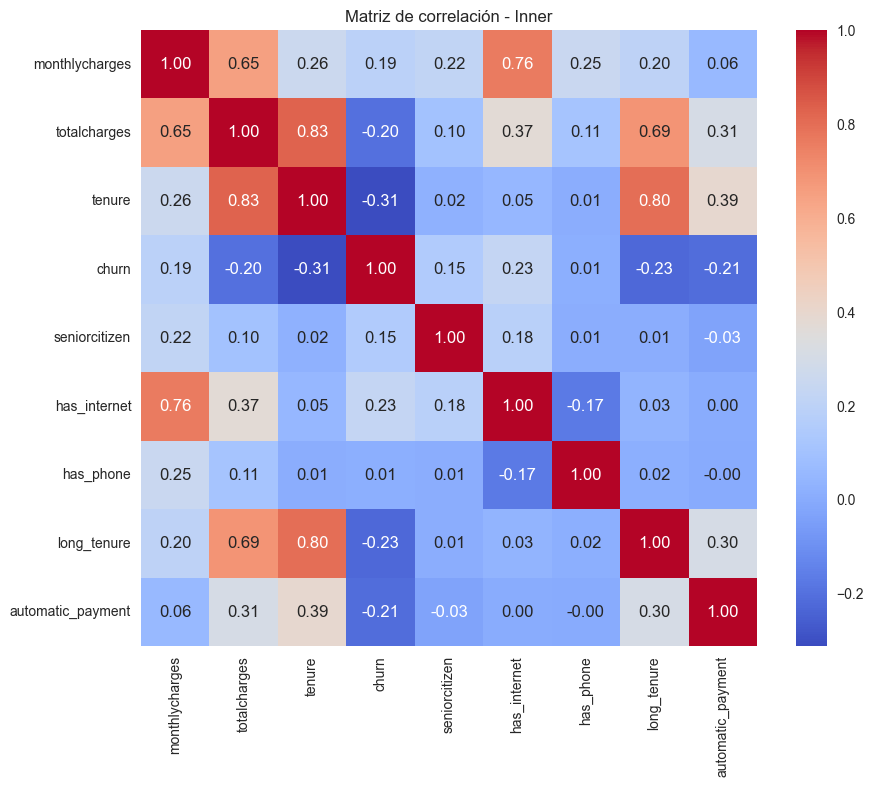

In [15]:
# Matriz de correlación y mapa de calor con las nuevas features
nuevas_feat = df_final_left.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(nuevas_feat, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de correlación - Inner")
plt.show()

Ahora sí, se tiene el DataSet completo con el join correcto y preprocesado. Ya había definido mi target ['churn'] en la variable (y) , sin embargo procedo a:
* Ver el balance de la clase ['churn']
* Definir mis features para hacer el split, y después el preprocesamiento correspondiente al train.

In [16]:
# Ver el balance de la clase target
display(df_final_left['churn'].value_counts().sort_index())
# Verla como porcentaje
display(df_final_left['churn'].value_counts(normalize=True).sort_index())

churn
0    5174
1    1869
Name: count, dtype: int64

churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

Existen 5174 clientes activos contra 1869 lo que equivale a 73.46 vs 26.53 % por lo que, de puede decir que existe un desbalance, pero no es tan grande como para arruinar la calidad durante el modelado, se evaluará utilizar estrategias como class_weight='balanced' para mitigar esto, o en su defecto, usar herramientas de sobre y submuestreo si es necesario.

Ahora sí se define X.

In [17]:
# Creación de features (X)
# Quitar columnas que no se usarán
X = df_final_left.drop(columns=['customerid', 'begindate', 'churn']) # El ID y la fecha no aportan valor predictivo.

Ya con X y y podemos hacer el split.

In [18]:
#Split con stratifiy para mantener la proporción de clases en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=17, stratify=y) 

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5986, 22)

(1057, 22)

(5986,)

(1057,)

Una vez establecidas qué columnas son de orden numérico y cuales son categóricas, se define el Pipeline con el que se trabajará. Las variables numéricas pasarán por un StandardScaler, mientras que, las categóricas se procesarán con un OHE debido a la baja cardinalidad de las categorías. Adicionalmente, utilizando SelectKBest se hará un feature importance, para ver qué features son las más representativas, y por el momento, se reduciarán a las 30 con mejor desempeño, a menos que a posteriori, el modelo necesite ajustarse.

In [19]:
# Definir columnas numéricas y categóricas para el ColumnTransformer
num_cols = ['tenure', 'long_tenure', 'monthlycharges', 'totalcharges'] #Seniorcitizen, has_internet y has_phone ya están codificadas
cat_cols = ['type', 'paperlessbilling', 'paymentmethod', 'automatic_payment', 'gender', 'partner', 'dependents', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines']

# Pipeline de preprocesamiento de escalado y codificación
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Escalado de características numéricas
    ])
cat_encoder = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])     
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', cat_encoder, cat_cols),
    ],
    remainder='passthrough' # Con este parámetro mantengo las columnas numéricas no procesadas
)
# Pipeline Final, se le aagrega SelectKBest para selección de características, de primera intención vamos a dejar 30 características.
pipeline = Pipeline(steps= [
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_classif, k=24)),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced')) 
])

# Ajuste con train 
pipeline.fit(X_train, y_train)
# Predicción
y_pred = pipeline.predict(X_test)

Vamos a visualizar los featuures que seleccionó SelectKBest.

In [20]:
# Variable para acceder al selector
pre = pipeline.named_steps['preprocessor']
selector = pipeline.named_steps['feature_selection']

# Obtener los nombres de las características seleccionadas
features_names = pre.get_feature_names_out()
# Visualización
mask = selector.get_support()
selected_features = np.array(features_names)[mask]
scores_all = selector.scores_
scores_k = scores_all[mask]

# DataFrame con los scores de las características seleccionadas
scores_df = pd.DataFrame({
    'feature': features_names[mask],
    'score': selector.scores_[mask]
}).sort_values(by='score', ascending=False)
scores_df

,feature,score
4,cat__type_Month-to-month,1154.662032
13,cat__onlinesecurity_No,833.680896
19,cat__techsupport_No,781.123649
0,num__tenure,624.220478
11,cat__internetservice_Fiber optic,615.211778
5,cat__type_Two year,592.465952
8,cat__paymentmethod_Electronic check,584.455764
15,cat__onlinebackup_No,445.539559
17,cat__deviceprotection_No,408.677476
22,cat__streamingmovies_NoInternet,334.371440


Para visualizar los features procesados: 

In [21]:
# Visualización de todas las features preprocesadas
# Transformación 
X_train_prep = pipeline.named_steps['preprocessor'].transform(X_train)
X_test_prep = pipeline.named_steps['preprocessor'].transform(X_test)

# Obtener las columnas que se pasan sin transformar
passthrough_cols = [c for c in X_train.columns if c not in (num_cols + cat_cols)]

# Obtener los nombres creados por el OneHotEncoder
ohe_features = pipeline.named_steps['preprocessor'] \
                       .named_transformers_['cat'] \
                       .named_steps['ohe'] \
                       .get_feature_names_out(cat_cols).tolist()

# Unir las columnas numéricas y las nuevas categóricas
all_features = num_cols + ohe_features + passthrough_cols

# Opcional, ver el resultado en un DF
X_train_prep_df = pd.DataFrame(X_train_prep, columns=all_features, index=X_train.index)
X_test_prep_df = pd.DataFrame(X_test_prep, columns = all_features, index=X_test.index)
X_test_prep_df.head(10)

,tenure,long_tenure,monthlycharges,totalcharges,type_Month-to-month,type_One year,type_Two year,paperlessbilling_No,paperlessbilling_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,automatic_payment_0,automatic_payment_1,gender_Female,gender_Male,partner_No,partner_Yes,dependents_No,dependents_Yes,internetservice_DSL,internetservice_Fiber optic,internetservice_NoInternet,onlinesecurity_No,onlinesecurity_NoInternet,onlinesecurity_Yes,onlinebackup_No,onlinebackup_NoInternet,onlinebackup_Yes,deviceprotection_No,deviceprotection_NoInternet,deviceprotection_Yes,techsupport_No,techsupport_NoInternet,techsupport_Yes,streamingtv_No,streamingtv_NoInternet,streamingtv_Yes,streamingmovies_No,streamingmovies_NoInternet,streamingmovies_Yes,multiplelines_No,multiplelines_NoPhone,multiplelines_Yes,seniorcitizen,has_internet,has_phone
6842,-0.830671,-0.584681,-1.491941,-0.897137,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1754,1.196381,1.710335,0.317877,1.069205,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
759,1.608040,1.710335,0.852331,1.895116,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
4859,1.237139,1.710335,1.456713,2.084841,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
5325,-1.160814,-0.584681,-1.471961,-0.966894,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
5798,-1.035821,-0.584681,0.680839,-0.800703,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
1431,0.411102,-0.584681,0.003198,0.276722,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
4025,-1.076580,-0.584681,0.334527,-0.868401,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
240,1.608040,1.710335,0.727458,1.800852,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0
1233,1.527882,1.710335,-1.333769,-0.264470,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [22]:
# Visualización del dataframe con las features seleccionadas y preprocesadas
X_train_selected = pipeline.named_steps['feature_selection'].transform(pipeline.named_steps['preprocessor'].transform(X_train))
X_test_selected = pipeline.named_steps['feature_selection'].transform(pipeline.named_steps['preprocessor'].transform(X_test))   

# Formar el DataFrame con las características seleccionadas
X_train_selected_df = pd.DataFrame(X_train_selected, columns=selected_features, index=X_train.index)
X_test_selected_df = pd.DataFrame(X_test_selected, columns=selected_features, index=X_test.index)

# Añadir el target en train
train_final_df = X_train_selected_df.copy()
train_final_df['target'] = y_train.values

# Añadir el target en test
test_final_df = X_test_selected_df.copy()
test_final_df['target'] = y_test.values

train_final_df

,num__tenure,num__long_tenure,num__monthlycharges,num__totalcharges,cat__type_Month-to-month,cat__type_Two year,cat__paperlessbilling_No,cat__paperlessbilling_Yes,cat__paymentmethod_Electronic check,cat__automatic_payment_0,cat__automatic_payment_1,cat__internetservice_Fiber optic,cat__internetservice_NoInternet,cat__onlinesecurity_No,cat__onlinesecurity_NoInternet,cat__onlinebackup_No,cat__onlinebackup_NoInternet,cat__deviceprotection_No,cat__deviceprotection_NoInternet,cat__techsupport_No,cat__techsupport_NoInternet,cat__streamingtv_NoInternet,cat__streamingmovies_NoInternet,remainder__has_internet,target
1110,1.112146,1.710335,-0.837609,0.062556,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
2368,1.608040,1.710335,1.744752,2.765636,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4853,0.824120,-0.584681,0.988858,1.221826,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3509,-1.326565,-0.584681,-0.661123,-0.991047,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0
4266,1.237139,1.710335,1.240268,1.879996,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6812,0.493977,-0.584681,0.697489,0.661883,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
100,-1.326565,-0.584681,-1.483616,-1.001983,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0
3305,0.203234,-0.584681,0.998848,0.606493,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0
6087,-0.292660,-0.584681,-0.825954,-0.557647,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0


**CONCLUSIONES DEL EDA**

--La información parte de cuatro tablas principales (contract, internet, personal, phone) que describen el estado contractual y de servicios de clientes.--

* Existen distribuciones esperadas (como los contratos “mes a mes” dominantes, alta proporción sin servicios adicionales) y ausencias con significado de negocio (como enddate vacío = contrato vigente).
* Con las visualizaciones automáticas por tipo de variable (numéricas y categóricas) se resaltan estas proporciones y patrones, que además, están explícitan en celdas MarkDown.
* Se usó la tabla contract (customerid) como base y se hicieron diferentes merges según la finalidad. Se trabaja con formatos DataFrames en vez de diccionario. Para los próximos pasos, lo más coherente es usar el DF hecho por un merge de left.

--Supuestos sobre los datos--

* ['enddate'] en realidad no son datos faltantes, sino fechas que todavía no han ocurrido. Para evitar el DataLeakage, la desición que tratarlo como una variable not a time; se usa en el EDA pero para el modelado no se usa ni esta columna ni columnas derivadas de esta para evitar el DL.
* Los identificadores (customerid) están bien formados y son únicos en cada tabla. No tienen valor predictivo.
* Las variables categóricas tienen cardinalidad baja usar un One-Hot Encoding fue la desición adecuada.

--Riesgos / problemáticas identificadas--

* Fuga de información si se usa la columna enddate cruda o atributos derivados con información “del futuro” podría sesgar el modelo.
* Existió una gran cantidad de valores nulos en caunto se hizo el merge, porque el método left conserva clientes pero deja columnas con NaN (sin internet/phone). Mitigación: Se rellenaron estos datos con valores categóricos.

Esto se tiene que tener en cuenta para la selección del algoritmo en nuestro modelo.

Una vez completado el EDA, habiendo enriquecido el Dataset con técnicas como feature engineering y feature selection, y haber empaquetado el preprocesamiento de mis features en un Pipeline, hacemos el modelado.  

## Modelado

**Primer modelo, Regresión Logística como prueba de cordura**

**Regresión Logística con todos los features**

              precision    recall  f1-score   support

           0       0.90      0.73      0.81       777
           1       0.51      0.79      0.62       280

    accuracy                           0.75      1057
   macro avg       0.71      0.76      0.72      1057
weighted avg       0.80      0.75      0.76      1057

AUC-ROC: 0.7590


['lr_af_model.pkl']

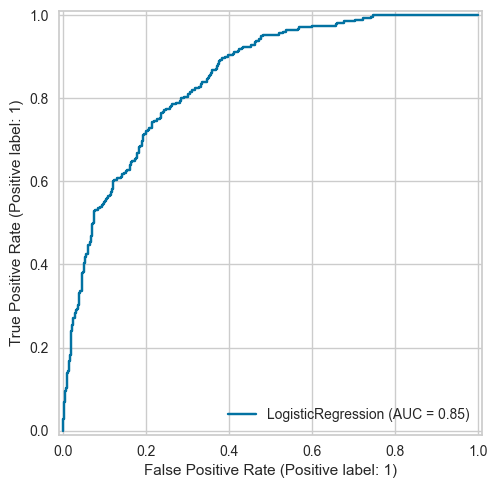

In [23]:
lr_af = LogisticRegression(max_iter=1000, class_weight='balanced')
# Entrenamiento
lr_af.fit(X_train_prep, y_train)
# Predicción
lr_af_y_pred = lr_af.predict(X_test_prep)
# Visualización
print(classification_report(y_test, lr_af_y_pred))
# AUC-ROC
lr_af_auc_roc = roc_auc_score(y_test, lr_af_y_pred)
print(f'AUC-ROC: {lr_af_auc_roc:.4f}')
# Grafica de la curva ROC
RocCurveDisplay.from_estimator(lr_af, X_test_prep, y_test)

# Guardar para no volver a entrenar
joblib.dump(lr_af, 'lr_af_model.pkl')
# Para cargar después:
# lr_af = joblib.load('lr_af_model.pkl')

Text(70.72222222222221, 0.5, 'Realidad')

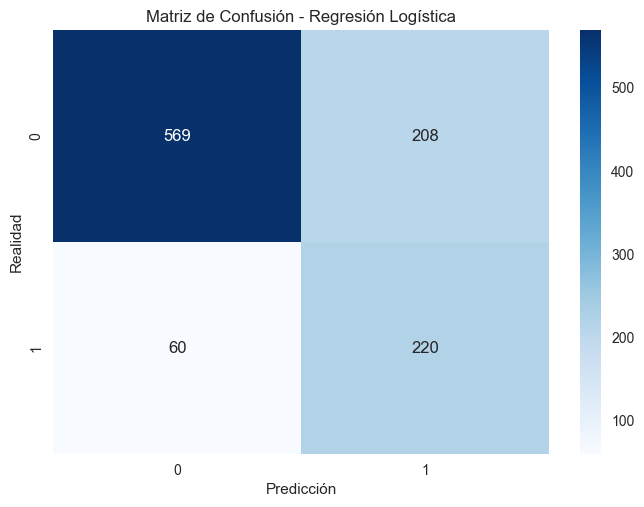

In [24]:
# Matriz de confusión
lr_af_cm = confusion_matrix(y_test, lr_af_y_pred)
sns.heatmap(lr_af_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Regresión Logística')
plt.xlabel('Predicción')
plt.ylabel('Realidad')

**Regresión Logística sobre los features seleccionados**

              precision    recall  f1-score   support

           0       0.92      0.72      0.81       777
           1       0.51      0.81      0.63       280

    accuracy                           0.75      1057
   macro avg       0.71      0.77      0.72      1057
weighted avg       0.81      0.75      0.76      1057

AUC-ROC: 0.7675


['lr_fs_model.pkl']

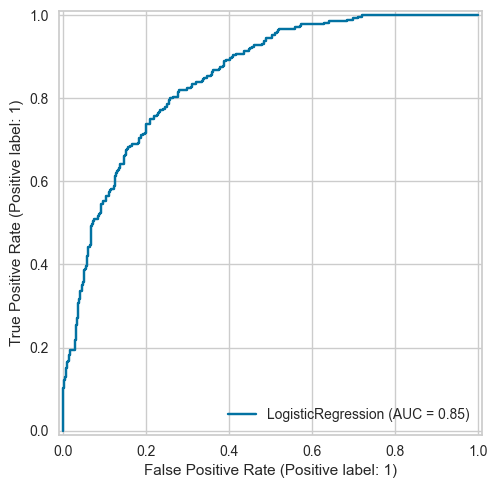

In [25]:
# Regresión logística con las features seleccionadas
lr_fs = LogisticRegression(max_iter=1000, class_weight='balanced')
# Entrenamiento
lr_fs.fit(X_train_selected, y_train)
# Predicción
lr_fs_y_pred = lr_fs.predict(X_test_selected)
# VIsualización
print(classification_report(y_test, lr_fs_y_pred))
# AUC-ROC 
lr_fs_auc_roc = roc_auc_score(y_test, lr_fs_y_pred)
print(f'AUC-ROC: {lr_fs_auc_roc:.4f}')
# Grafica de la curva ROC
RocCurveDisplay.from_estimator(lr_fs, X_test_selected, y_test)

# Guardar para no volver a entrenar
joblib.dump(lr_fs, 'lr_fs_model.pkl')
# Para cargar después:
# lr_fs = joblib.load('lr_fs_model.pkl')

Text(70.72222222222221, 0.5, 'Realidad')

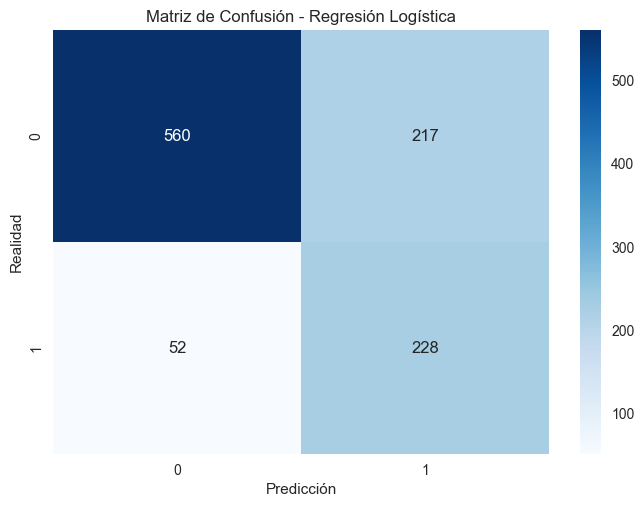

In [ ]:
# Matriz de confusión
lr_cm = confusion_matrix(y_test, lr_fs_y_pred)
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Regresión Logística')
plt.xlabel('Predicción')
plt.ylabel('Realidad')

Lógicamente, el modelo tiene la misma métrica cuando se usan todas las features, ahora voy a ajustar mi número en feature_selection para ver cómo es que cambia la métrica con respecto al valor predictivo de mis features:

* Todas las features (48 features) vs features seleccionadas (48) : AUC-ROC: 0.7590 - AUC-ROC: 0.7590 (Esperado)
* **Todas las features (48 features) vs features seleccionadas (24) : AUC-ROC: 0.7590 - AUC-ROC: 0.7675 (FI scores mayores a 200)**
* Todas las features (48 features) vs features seleccionadas (18) : AUC-ROC: 0.7590 - AUC-ROC: 0.7641 (FI scores mayores a 300)
* Todas las features (48 features) vs features seleccionadas (9) : AUC-ROC: 0.7590 - AUC-ROC: 0.7593 (FI scores mayores a 400)
* Todas las features (48 features) vs features seleccionadas (7): AUC-ROC: 0.7590 - AUC-ROC: 0.7596 (FI scores mayores a 500)

Con este análisis, puedo concluir que el modelo posee mayor capacidad predictva, cuando se usan 24 features, que corresponden a aquellos que el feature_importance les dió un score mayor a 200. Con más, o menos features, el modelo obtiene peor métricas.

Realmente no existió un cambio drástico con el ajuste del número de features utilizadas para encontrar el mejor score AUC-ROC, sin embargo, sí se encontró que usando los features con un FI score mayores a 200, el modelo llegó al pico de predicción. No necesariamente, lo que funciona para una RL funciona para un RFR o un XGBoost, por lo que se entrenarán con ambas ventanas.

Ya se utilizó una Regresión Logística como prueba de cordura, es momento de utilizar herramientas como Pycaret para realizar un acercamiento a qué algoritmo podría venir mejor.

In [26]:
# Inicialización de PyCaret 
# Pycaret con el dataframe completo
df_all = X_train_prep_df.assign(target=y_train.values)
a = pc.setup(data=df_all, target='target', session_id=17, verbose=False)
best_all = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8773,0.9200,0.6556,0.8484,0.7392,0.6607,0.6704,2.8480
xgboost,Extreme Gradient Boosting,0.8761,0.9202,0.6826,0.8224,0.7450,0.6642,0.6699,0.1440
lightgbm,Light Gradient Boosting Machine,0.8754,0.9197,0.6610,0.8372,0.7377,0.6576,0.6662,0.2160
gbc,Gradient Boosting Classifier,0.8585,0.9044,0.6115,0.8106,0.6957,0.6060,0.6172,0.3760
ada,Ada Boost Classifier,0.8535,0.8972,0.6259,0.7788,0.6928,0.5983,0.6053,0.1280
rf,Random Forest Classifier,0.8131,0.8518,0.5468,0.6849,0.6078,0.4872,0.4927,0.2070
lr,Logistic Regression,0.8021,0.8421,0.5459,0.6520,0.5938,0.4645,0.4679,0.9170
dt,Decision Tree Classifier,0.8012,0.7507,0.6431,0.6223,0.6316,0.4957,0.4965,0.0330
ridge,Ridge Classifier,0.7995,0.8401,0.5180,0.6542,0.5777,0.4487,0.4542,0.0250
lda,Linear Discriminant Analysis,0.7962,0.8401,0.5513,0.6331,0.5890,0.4544,0.4566,0.0370


In [27]:
# Pycaret con el dataframe seleccionado
df_selected = train_final_df
s = pc.setup(data=df_selected, target='target', session_id=17, verbose=False)
best_selected = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8838,0.9225,0.6664,0.8651,0.7523,0.6781,0.6883,2.0460
xgboost,Extreme Gradient Boosting,0.8828,0.9251,0.6943,0.8380,0.7584,0.6821,0.6880,0.0670
lightgbm,Light Gradient Boosting Machine,0.8780,0.9208,0.6620,0.8458,0.7417,0.6636,0.6727,0.2360
gbc,Gradient Boosting Classifier,0.8604,0.9047,0.6088,0.8206,0.6981,0.6099,0.6220,0.2340
ada,Ada Boost Classifier,0.8489,0.8964,0.6214,0.7655,0.6841,0.5866,0.5933,0.1050
rf,Random Forest Classifier,0.8277,0.8632,0.5782,0.7182,0.6402,0.5287,0.5344,0.1950
dt,Decision Tree Classifier,0.8122,0.7599,0.6484,0.6470,0.6470,0.5191,0.5197,0.0240
et,Extra Trees Classifier,0.7993,0.8380,0.5566,0.6418,0.5951,0.4628,0.4655,0.2070
lr,Logistic Regression,0.7959,0.8393,0.5162,0.6435,0.5724,0.4407,0.4455,0.0330
ridge,Ridge Classifier,0.7931,0.8366,0.4929,0.6438,0.5578,0.4260,0.4327,0.0190


Pycaret sugirió que, tanto para el DataFrame que tiene todas la features, como para el DataFrame con las 24 features seleccionadas, para optimiar la métrica AUC-ROC los algortimos que sería una buena idea utilizar son:
* XGBoost
* LightGBM
* Catboost

Sin embargo, también se modelarán los datos utilizando algoritmos basados en árboles de decisiones como:

* Decision Tree Classifier
* Random Forest Classifier

**Decision Tree Classifier**

Fitting 5 folds for each of 144 candidates, totalling 720 fits
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       777
           1       0.60      0.76      0.68       280

    accuracy                           0.81      1057
   macro avg       0.76      0.79      0.77      1057
weighted avg       0.83      0.81      0.81      1057

AUC-ROC: 0.7921
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       777
           1       0.60      0.76      0.68       280

    accuracy                           0.81      1057
   macro avg       0.76      0.79      0.77      1057
weighted avg       0.83      0.81      0.81      1057

AUC-ROC: 0.7921


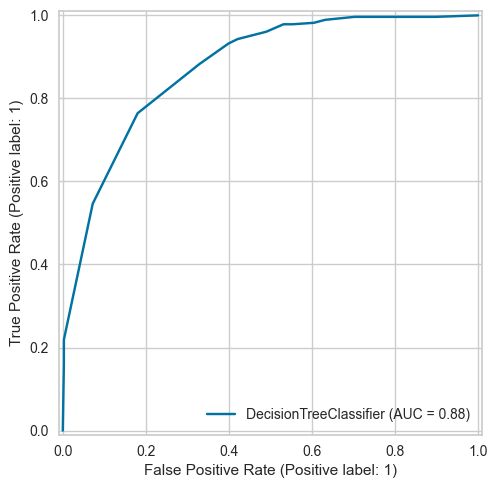

In [28]:
# GridSearch para Decision Tree Classifier

#Param grid 
param_grid_dtc = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', None],
}

# Aplicar GridSearchCV
gd_dtc_af = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid_dtc, 
                      scoring='roc_auc', cv=5, n_jobs=-1, verbose=2)
gd_dtc_af.fit(X_train_prep, y_train)

dtc_af_best = gd_dtc_af.best_estimator_ 

# Entrenamiento
dtc_af_best.fit(X_train_prep, y_train)
# Predicción
dtc_af_y_pred = dtc_af_best.predict(X_test_prep)
# Visualización
print(classification_report(y_test, dtc_af_y_pred))
# AUC-ROC 
dtc_af_auc_roc = roc_auc_score(y_test, dtc_af_y_pred)
print(f'AUC-ROC: {dtc_af_auc_roc:.4f}')
# Grafica de la curva ROC
RocCurveDisplay.from_estimator(dtc_af_best, X_test_prep, y_test)

Text(70.72222222222221, 0.5, 'Realidad')

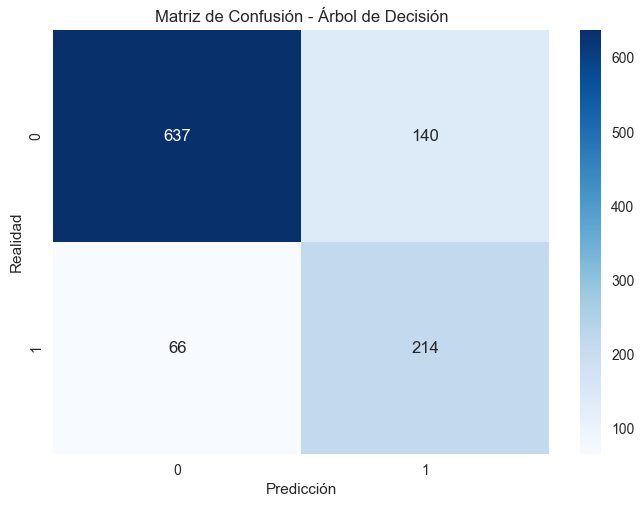

In [29]:
# Matriz de confusión
cm_dtc_af_best = confusion_matrix(y_test, dtc_af_y_pred)
sns.heatmap(cm_dtc_af_best, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Árbol de Decisión')
plt.xlabel('Predicción')
plt.ylabel('Realidad')

Fitting 5 folds for each of 144 candidates, totalling 720 fits
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       777
           1       0.60      0.76      0.68       280

    accuracy                           0.81      1057
   macro avg       0.76      0.79      0.77      1057
weighted avg       0.83      0.81      0.81      1057

AUC-ROC: 0.7921
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       777
           1       0.60      0.76      0.68       280

    accuracy                           0.81      1057
   macro avg       0.76      0.79      0.77      1057
weighted avg       0.83      0.81      0.81      1057

AUC-ROC: 0.7921


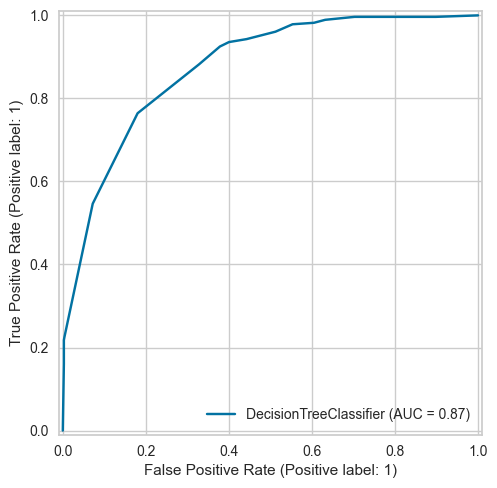

In [30]:
# Decision Tree Classifier con todas las featureas

# Aplicar GridSearchCV
gd_dtc_fs = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid_dtc, 
                      scoring='roc_auc', cv=5, n_jobs=-1, verbose=2)
gd_dtc_fs.fit(X_train_selected, y_train)

dtc_fs_best = gd_dtc_fs.best_estimator_

# Entrenamiento
dtc_fs_best.fit(X_train_selected, y_train)
# Predicción
dtc_fs_y_pred = dtc_fs_best.predict(X_test_selected)
# Visualización
print(classification_report(y_test, dtc_fs_y_pred))
# AUC-ROC 
dtc_fs_auc_roc = roc_auc_score(y_test, dtc_fs_y_pred)
print(f'AUC-ROC: {dtc_fs_auc_roc:.4f}')
# Grafica de la curva ROC
RocCurveDisplay.from_estimator(dtc_fs_best, X_test_selected, y_test)

Text(70.72222222222221, 0.5, 'Realidad')

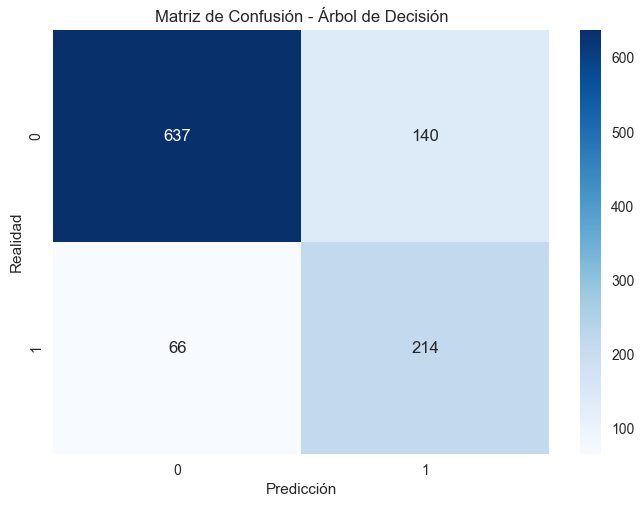

In [31]:
# Matriz de confusión
cm_dtc_fs_best = confusion_matrix(y_test, dtc_fs_y_pred)
sns.heatmap(cm_dtc_fs_best, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Árbol de Decisión')
plt.xlabel('Predicción')
plt.ylabel('Realidad')

Random Forest Classifier

Iniciando GridSearch para Random Forest con todas las features

Resultados Random Forest (todas las features):
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       777
           1       0.85      0.67      0.75       280

    accuracy                           0.88      1057
   macro avg       0.87      0.81      0.84      1057
weighted avg       0.88      0.88      0.88      1057

AUC-ROC: 0.9237

Resultados Random Forest (todas las features):
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       777
           1       0.85      0.67      0.75       280

    accuracy                           0.88      1057
   macro avg       0.87      0.81      0.84      1057
weighted avg       0.88      0.88      0.88      1057

AUC-ROC: 0.9237


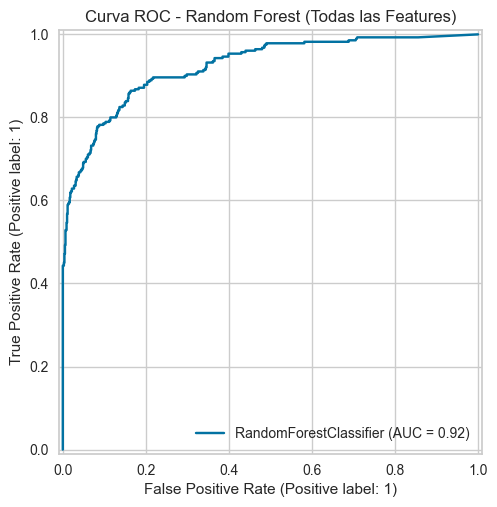

['rf_af_best_model.pkl']

In [ ]:
# Random Forest Classifier con todas las features
# GridSearch para Random Forest Classifier

# Param grid para Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', None]
}

# Aplicar GridSearchCV para Random Forest (todas las features)
print("Iniciando GridSearch para Random Forest con todas las features")
gd_rf_af = GridSearchCV(estimator=RandomForestClassifier(random_state=42), 
                        param_grid=param_grid_rf, 
                        scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
rf_af_best = joblib.load('rf_af_best_model.pkl')
# gd_rf_af.fit(X_train_prep, y_train)

# rf_af_best = gd_rf_af.best_estimator_
# print(f"Mejores parámetros Random Forest (todas las features):")
# print(f"Mejor score Random Forest (todas las features):")

# Predicción y evaluación
# rf_af_y_pred = rf_af_best.predict(X_test_prep)
# rf_af_y_pred_proba = rf_af_best.predict_proba(X_test_prep)[:, 1]

print("\nResultados Random Forest (todas las features):")
print(classification_report(y_test, rf_af_y_pred))
rf_af_auc_roc = roc_auc_score(y_test, rf_af_y_pred_proba)
print(f'AUC-ROC: {rf_af_auc_roc:.4f}')

# Grafica de la curva ROC
RocCurveDisplay.from_estimator(rf_af_best, X_test_prep, y_test)
plt.title('Curva ROC - Random Forest (Todas las Features)')
plt.show()

# Guardar para no volver a entrenar
joblib.dump(rf_af_best, 'rf_af_best_model.pkl')
# Para cargar después:
# rf_af_best = joblib.load('rf_af_best_model.pkl')

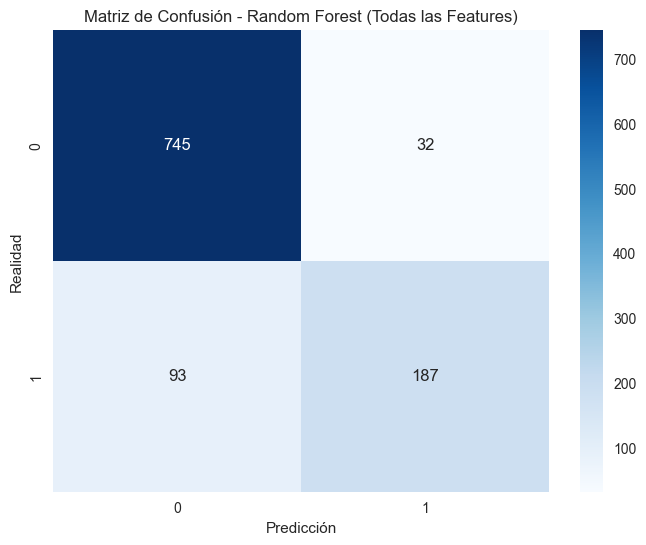

In [ ]:
# Matriz de confusión Random Forest (todas las features)
cm_rf_af_best = confusion_matrix(y_test, rf_af_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf_af_best, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Random Forest (Todas las Features)')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

Iniciando GridSearch para Random Forest con features seleccionadas...
Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Mejores parámetros Random Forest (features seleccionadas):
Mejor score Random Forest (features seleccionadas):

Resultados Random Forest (features seleccionadas):
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       777
           1       0.85      0.68      0.76       280

    accuracy                           0.88      1057
   macro avg       0.87      0.82      0.84      1057
weighted avg       0.88      0.88      0.88      1057

AUC-ROC: 0.9286


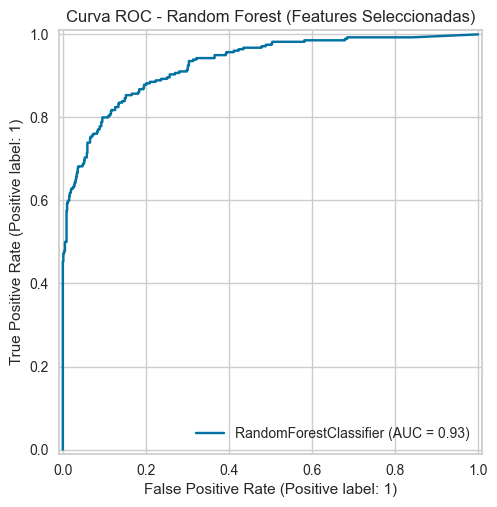

['rf_fs_best_model.pkl']

In [ ]:
# Random Forest Classifier con las features seleccionadas
# Aplicar GridSearchCV para Random Forest (features seleccionadas)
print("Iniciando GridSearch para Random Forest con features seleccionadas...")
gd_rf_fs = GridSearchCV(estimator=RandomForestClassifier(random_state=42), 
                        param_grid=param_grid_rf, 
                        scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
gd_rf_fs.fit(X_train_selected, y_train)

rf_fs_best = gd_rf_fs.best_estimator_
print(f"Mejores parámetros Random Forest (features seleccionadas):")
print(f"Mejor score Random Forest (features seleccionadas):")

# Predicción y evaluación
rf_fs_y_pred = rf_fs_best.predict(X_test_selected)
rf_fs_y_pred_proba = rf_fs_best.predict_proba(X_test_selected)[:, 1]

print("\nResultados Random Forest (features seleccionadas):")
print(classification_report(y_test, rf_fs_y_pred))
rf_fs_auc_roc = roc_auc_score(y_test, rf_fs_y_pred_proba)
print(f'AUC-ROC: {rf_fs_auc_roc:.4f}')

# Grafica de la curva ROC
RocCurveDisplay.from_estimator(rf_fs_best, X_test_selected, y_test)
plt.title('Curva ROC - Random Forest (Features Seleccionadas)')
plt.show()

# Guardar para no volver a entrenar
joblib.dump(rf_fs_best, 'rf_fs_best_model.pkl')
# Para cargar después:
# rf_fs_best = joblib.load('rf_fs_best_model.pkl')

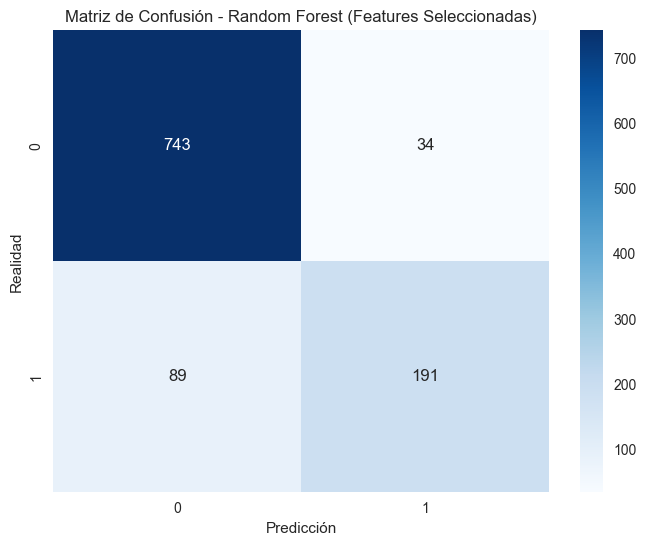

In [ ]:
# Matriz de confusión Random Forest (features seleccionadas)
cm_rf_fs_best = confusion_matrix(y_test, rf_fs_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf_fs_best, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Random Forest (Features Seleccionadas)')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

CatBoost

Iniciando GridSearch para CatBoost con todas las features...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Mejores parámetros CatBoost (todas las features): {'border_count': 128, 'depth': 4, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.2}
Mejor score CatBoost (todas las features): 0.9364

Resultados CatBoost (todas las features):
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       777
           1       0.88      0.76      0.82       280

    accuracy                           0.91      1057
   macro avg       0.90      0.86      0.88      1057
weighted avg       0.91      0.91      0.91      1057

AUC-ROC: 0.9452


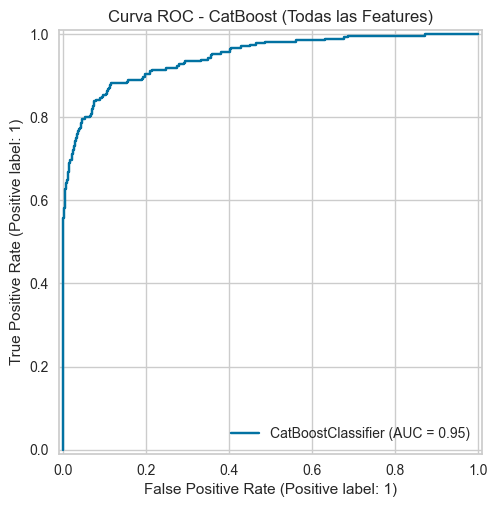

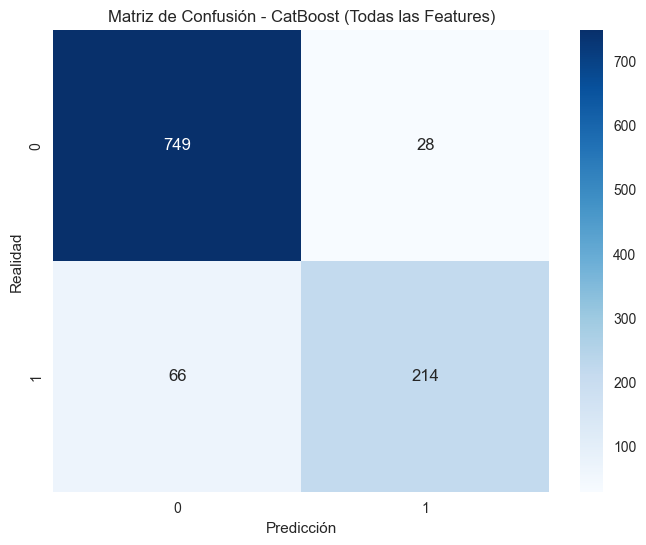

['catboost_af_best_model.pkl']

In [ ]:
# CatBoost con todas las features
# GridSearch para CatBoost

# Param grid para CatBoost
param_grid_catboost = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'iterations': [100, 200, 300],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 64, 128]
}

# Aplicar GridSearchCV para CatBoost (todas las features)
print("Iniciando GridSearch para CatBoost con todas las features...")
gd_catboost_af = GridSearchCV(estimator=CatBoostClassifier(random_state=42, verbose=False), 
                              param_grid=param_grid_catboost, 
                              scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
gd_catboost_af.fit(X_train_prep, y_train)

catboost_af_best = gd_catboost_af.best_estimator_
print(f"Mejores parámetros CatBoost (todas las features): {gd_catboost_af.best_params_}")
print(f"Mejor score CatBoost (todas las features): {gd_catboost_af.best_score_:.4f}")

# Predicción y evaluación
catboost_af_y_pred = catboost_af_best.predict(X_test_prep)
catboost_af_y_pred_proba = catboost_af_best.predict_proba(X_test_prep)[:, 1]

print("\nResultados CatBoost (todas las features):")
print(classification_report(y_test, catboost_af_y_pred))
catboost_af_auc_roc = roc_auc_score(y_test, catboost_af_y_pred_proba)
print(f'AUC-ROC: {catboost_af_auc_roc:.4f}')

# Grafica de la curva ROC
RocCurveDisplay.from_estimator(catboost_af_best, X_test_prep, y_test)
plt.title('Curva ROC - CatBoost (Todas las Features)')
plt.show()

# Matriz de confusión
cm_catboost_af_best = confusion_matrix(y_test, catboost_af_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_catboost_af_best, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - CatBoost (Todas las Features)')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

# Guardar para no volver a entrenar
joblib.dump(catboost_af_best, 'catboost_af_best_model.pkl')
# Para cargar después:
# catboost_af_best = joblib.load('catboost_af_best_model.pkl')

Iniciando GridSearch para CatBoost con features seleccionadas...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Mejores parámetros CatBoost (features seleccionadas): {'border_count': 128, 'depth': 4, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.2}
Mejor score CatBoost (features seleccionadas): 0.9410

Resultados CatBoost (features seleccionadas):
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       777
           1       0.88      0.76      0.82       280

    accuracy                           0.91      1057
   macro avg       0.90      0.86      0.88      1057
weighted avg       0.91      0.91      0.91      1057

AUC-ROC: 0.9535


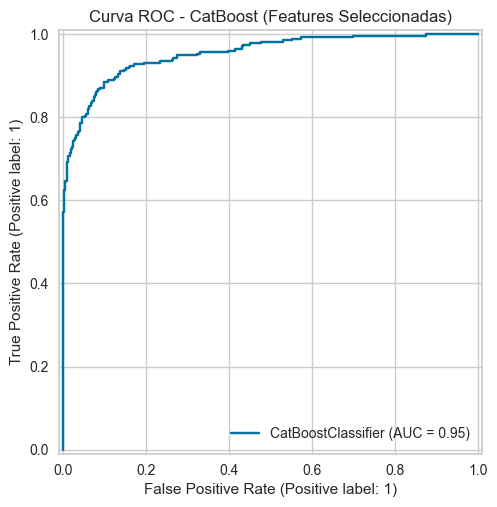

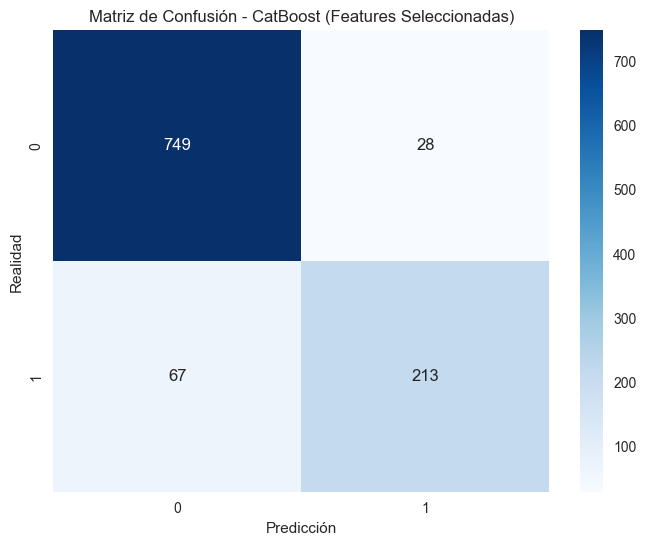

['catboost_fs_best_model.pkl']

In [ ]:
# CatBoost con las features seleccionadas
# Aplicar GridSearchCV para CatBoost (features seleccionadas)
print("Iniciando GridSearch para CatBoost con features seleccionadas...")
gd_catboost_fs = GridSearchCV(estimator=CatBoostClassifier(random_state=42, verbose=False), 
                              param_grid=param_grid_catboost, 
                              scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
gd_catboost_fs.fit(X_train_selected, y_train)

catboost_fs_best = gd_catboost_fs.best_estimator_
print(f"Mejores parámetros CatBoost (features seleccionadas): {gd_catboost_fs.best_params_}")
print(f"Mejor score CatBoost (features seleccionadas): {gd_catboost_fs.best_score_:.4f}")

# Predicción y evaluación
catboost_fs_y_pred = catboost_fs_best.predict(X_test_selected)
catboost_fs_y_pred_proba = catboost_fs_best.predict_proba(X_test_selected)[:, 1]

print("\nResultados CatBoost (features seleccionadas):")
print(classification_report(y_test, catboost_fs_y_pred))
catboost_fs_auc_roc = roc_auc_score(y_test, catboost_fs_y_pred_proba)
print(f'AUC-ROC: {catboost_fs_auc_roc:.4f}')

# Grafica de la curva ROC
RocCurveDisplay.from_estimator(catboost_fs_best, X_test_selected, y_test)
plt.title('Curva ROC - CatBoost (Features Seleccionadas)')
plt.show()

# Matriz de confusión
cm_catboost_fs_best = confusion_matrix(y_test, catboost_fs_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_catboost_fs_best, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - CatBoost (Features Seleccionadas)')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

# Guardar para no volver a entrenar
joblib.dump(catboost_fs_best, 'catboost_fs_best_model.pkl')
# Para cargar después:
# catboost_fs_best = joblib.load('catboost_fs_best_model.pkl')

LightGBM

Iniciando GridSearch para LightGBM con todas las features...
Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Mejores parámetros LightGBM (todas las features): {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'n_estimators': 300, 'num_leaves': 31, 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'subsample': 0.8}
Mejor score LightGBM (todas las features): 0.9401

Resultados LightGBM (todas las features):
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       777
           1       0.88      0.80      0.84       280

    accuracy                           0.92      1057
   macro avg       0.90      0.88      0.89      1057
weighted avg       0.92      0.92      0.92      1057

AUC-ROC: 0.9510


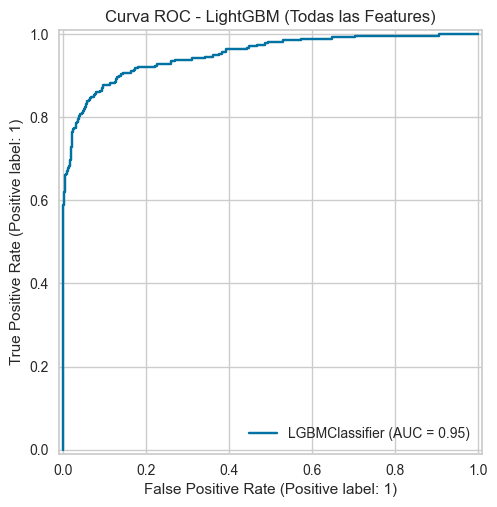

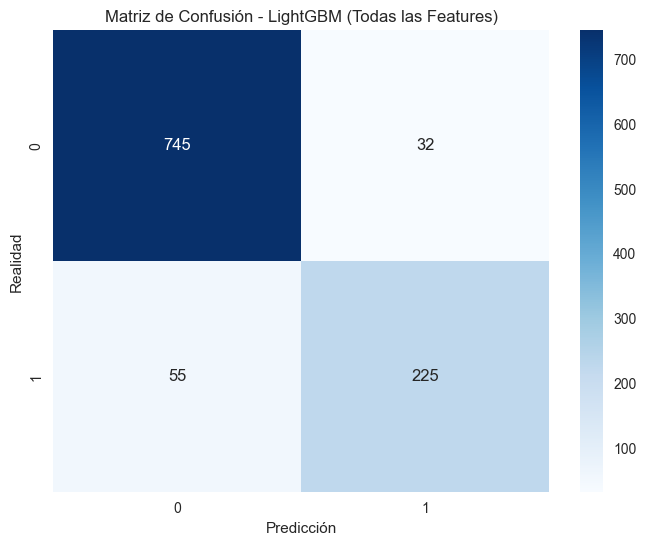

['lightgbm_af_best_model.pkl']

In [ ]:
# LightGBM con todas las features
# GridSearch para LightGBM

# Param grid para LightGBM
param_grid_lightgbm = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

# Aplicar GridSearchCV para LightGBM (todas las features)
print("Iniciando GridSearch para LightGBM con todas las features...")
gd_lightgbm_af = GridSearchCV(estimator=LGBMClassifier(random_state=42, verbose=-1), 
                              param_grid=param_grid_lightgbm, 
                              scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
gd_lightgbm_af.fit(X_train_prep, y_train)

lightgbm_af_best = gd_lightgbm_af.best_estimator_
print(f"Mejores parámetros LightGBM (todas las features): {gd_lightgbm_af.best_params_}")
print(f"Mejor score LightGBM (todas las features): {gd_lightgbm_af.best_score_:.4f}")

# Predicción y evaluación
lightgbm_af_y_pred = lightgbm_af_best.predict(X_test_prep)
lightgbm_af_y_pred_proba = lightgbm_af_best.predict_proba(X_test_prep)[:, 1]

print("\nResultados LightGBM (todas las features):")
print(classification_report(y_test, lightgbm_af_y_pred))
lightgbm_af_auc_roc = roc_auc_score(y_test, lightgbm_af_y_pred_proba)
print(f'AUC-ROC: {lightgbm_af_auc_roc:.4f}')

# Grafica de la curva ROC
RocCurveDisplay.from_estimator(lightgbm_af_best, X_test_prep, y_test)
plt.title('Curva ROC - LightGBM (Todas las Features)')
plt.show()

# Matriz de confusión
cm_lightgbm_af_best = confusion_matrix(y_test, lightgbm_af_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lightgbm_af_best, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - LightGBM (Todas las Features)')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

# Guardar para no volver a entrenar
joblib.dump(lightgbm_af_best, 'lightgbm_af_best_model.pkl')
# Para cargar después:
# lightgbm_af_best = joblib.load('lightgbm_af_best_model.pkl')

Iniciando GridSearch para LightGBM con features seleccionadas...
Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Mejores parámetros LightGBM (features seleccionadas): {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'n_estimators': 300, 'num_leaves': 31, 'reg_alpha': 0.5, 'reg_lambda': 0, 'subsample': 0.8}
Mejor score LightGBM (features seleccionadas): 0.9420

Resultados LightGBM (features seleccionadas):
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       777
           1       0.87      0.80      0.83       280

    accuracy                           0.92      1057
   macro avg       0.90      0.88      0.89      1057
weighted avg       0.91      0.92      0.91      1057

AUC-ROC: 0.9539


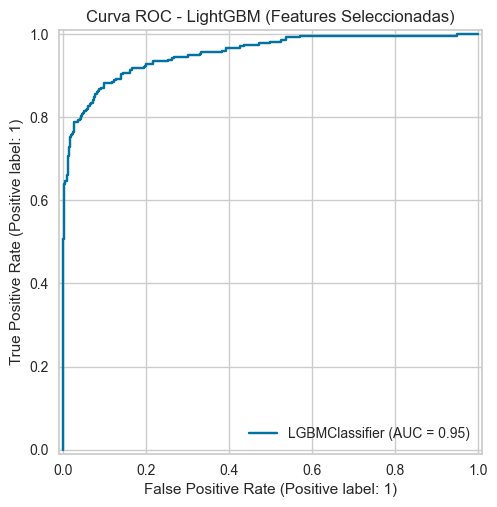

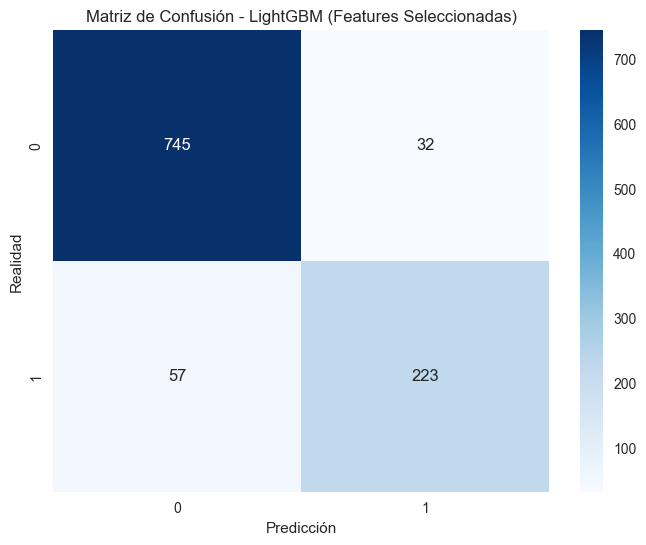

['lightgbm_fs_best_model.pkl']

In [ ]:
# LightGBM con las features seleccionadas
# Aplicar GridSearchCV para LightGBM (features seleccionadas)
print("Iniciando GridSearch para LightGBM con features seleccionadas...")
gd_lightgbm_fs = GridSearchCV(estimator=LGBMClassifier(random_state=42, verbose=-1), 
                              param_grid=param_grid_lightgbm, 
                              scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
gd_lightgbm_fs.fit(X_train_selected, y_train)

lightgbm_fs_best = gd_lightgbm_fs.best_estimator_
print(f"Mejores parámetros LightGBM (features seleccionadas): {gd_lightgbm_fs.best_params_}")
print(f"Mejor score LightGBM (features seleccionadas): {gd_lightgbm_fs.best_score_:.4f}")

# Predicción y evaluación
lightgbm_fs_y_pred = lightgbm_fs_best.predict(X_test_selected)
lightgbm_fs_y_pred_proba = lightgbm_fs_best.predict_proba(X_test_selected)[:, 1]

print("\nResultados LightGBM (features seleccionadas):")
print(classification_report(y_test, lightgbm_fs_y_pred))
lightgbm_fs_auc_roc = roc_auc_score(y_test, lightgbm_fs_y_pred_proba)
print(f'AUC-ROC: {lightgbm_fs_auc_roc:.4f}')

# Grafica de la curva ROC
RocCurveDisplay.from_estimator(lightgbm_fs_best, X_test_selected, y_test)
plt.title('Curva ROC - LightGBM (Features Seleccionadas)')
plt.show()

# Matriz de confusión
cm_lightgbm_fs_best = confusion_matrix(y_test, lightgbm_fs_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lightgbm_fs_best, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - LightGBM (Features Seleccionadas)')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

# Guardar para no volver a entrenar
joblib.dump(lightgbm_fs_best, 'lightgbm_fs_best_model.pkl')
# Para cargar después:
# lightgbm_fs_best = joblib.load('lightgbm_fs_best_model.pkl')

XGBoost

Iniciando GridSearch para XGBoost con todas las features...
Fitting 5 folds for each of 2916 candidates, totalling 14580 fits
Mejores parámetros XGBoost (todas las features): {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 300, 'reg_alpha': 0.5, 'reg_lambda': 0, 'subsample': 0.8}
Mejor score XGBoost (todas las features): 0.9409

Resultados XGBoost (todas las features):
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       777
           1       0.87      0.79      0.83       280

    accuracy                           0.91      1057
   macro avg       0.90      0.87      0.89      1057
weighted avg       0.91      0.91      0.91      1057

AUC-ROC: 0.9466


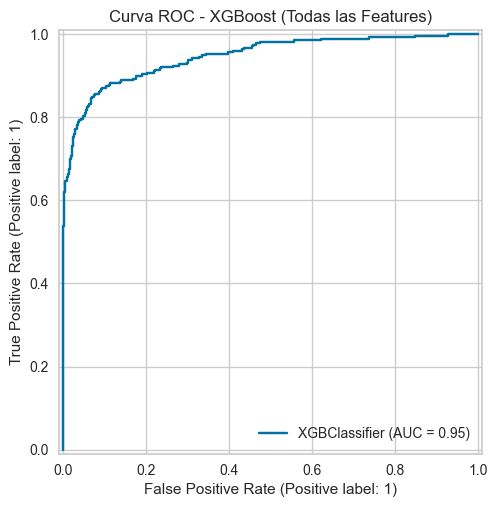

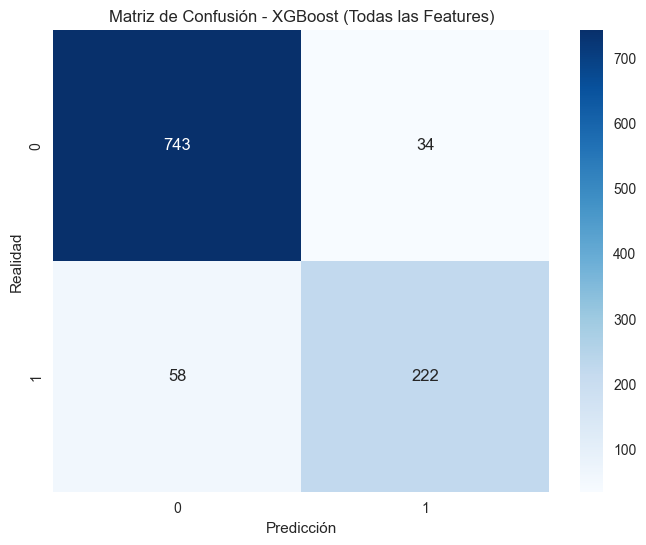

['xgboost_af_best_model.pkl']

In [ ]:
# XGBoost con todas las features
# GridSearch para XGBoost

# Param grid para XGBoost
param_grid_xgboost = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

# Aplicar GridSearchCV para XGBoost (todas las features)
print("Iniciando GridSearch para XGBoost con todas las features...")
gd_xgboost_af = GridSearchCV(estimator=XGBClassifier(random_state=42, eval_metric='logloss'), 
                             param_grid=param_grid_xgboost, 
                             scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
gd_xgboost_af.fit(X_train_prep, y_train)

xgboost_af_best = gd_xgboost_af.best_estimator_
print(f"Mejores parámetros XGBoost (todas las features): {gd_xgboost_af.best_params_}")
print(f"Mejor score XGBoost (todas las features): {gd_xgboost_af.best_score_:.4f}")

# Predicción y evaluación
xgboost_af_y_pred = xgboost_af_best.predict(X_test_prep)
xgboost_af_y_pred_proba = xgboost_af_best.predict_proba(X_test_prep)[:, 1]

print("\nResultados XGBoost (todas las features):")
print(classification_report(y_test, xgboost_af_y_pred))
xgboost_af_auc_roc = roc_auc_score(y_test, xgboost_af_y_pred_proba)
print(f'AUC-ROC: {xgboost_af_auc_roc:.4f}')

# Grafica de la curva ROC
RocCurveDisplay.from_estimator(xgboost_af_best, X_test_prep, y_test)
plt.title('Curva ROC - XGBoost (Todas las Features)')
plt.show()

# Matriz de confusión
cm_xgboost_af_best = confusion_matrix(y_test, xgboost_af_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgboost_af_best, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - XGBoost (Todas las Features)')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

# Guardar para no volver a entrenar
joblib.dump(xgboost_af_best, 'xgboost_af_best_model.pkl')
# Para cargar después:
# xgboost_af_best = joblib.load('xgboost_af_best.pkl')

Iniciando GridSearch para XGBoost con features seleccionadas...
Fitting 5 folds for each of 2916 candidates, totalling 14580 fits
Mejores parámetros XGBoost (features seleccionadas): {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 300, 'reg_alpha': 0.5, 'reg_lambda': 0.5, 'subsample': 0.8}
Mejor score XGBoost (features seleccionadas): 0.9450

Resultados XGBoost (features seleccionadas):
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       777
           1       0.88      0.79      0.83       280

    accuracy                           0.91      1057
   macro avg       0.90      0.87      0.89      1057
weighted avg       0.91      0.91      0.91      1057

AUC-ROC: 0.9552


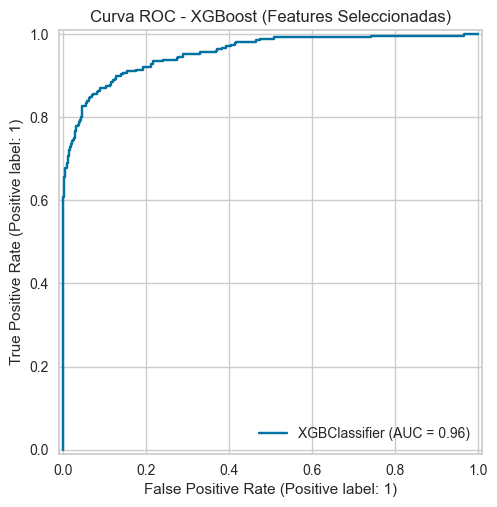

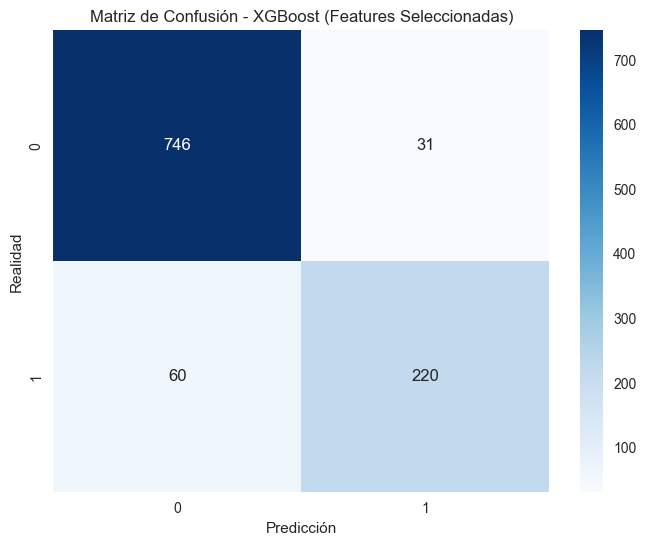

['xgboost_fs_best_model.pkl']

In [ ]:
# XGBoost con las features seleccionadas
# Aplicar GridSearchCV para XGBoost (features seleccionadas)
print("Iniciando GridSearch para XGBoost con features seleccionadas...")
gd_xgboost_fs = GridSearchCV(estimator=XGBClassifier(random_state=42, eval_metric='logloss'), 
                             param_grid=param_grid_xgboost, 
                             scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)
gd_xgboost_fs.fit(X_train_selected, y_train)

xgboost_fs_best = gd_xgboost_fs.best_estimator_
print(f"Mejores parámetros XGBoost (features seleccionadas): {gd_xgboost_fs.best_params_}")
print(f"Mejor score XGBoost (features seleccionadas): {gd_xgboost_fs.best_score_:.4f}")

# Predicción y evaluación
xgboost_fs_y_pred = xgboost_fs_best.predict(X_test_selected)
xgboost_fs_y_pred_proba = xgboost_fs_best.predict_proba(X_test_selected)[:, 1]

print("\nResultados XGBoost (features seleccionadas):")
print(classification_report(y_test, xgboost_fs_y_pred))
xgboost_fs_auc_roc = roc_auc_score(y_test, xgboost_fs_y_pred_proba)
print(f'AUC-ROC: {xgboost_fs_auc_roc:.4f}')

# Grafica de la curva ROC
RocCurveDisplay.from_estimator(xgboost_fs_best, X_test_selected, y_test)
plt.title('Curva ROC - XGBoost (Features Seleccionadas)')
plt.show()

# Matriz de confusión
cm_xgboost_fs_best = confusion_matrix(y_test, xgboost_fs_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgboost_fs_best, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - XGBoost (Features Seleccionadas)')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

# Guardar para no volver a entrenar
joblib.dump(xgboost_fs_best, 'xgboost_fs_best_model.pkl')
# Para cargar después:
# xgboost_fs_best = joblib.load('xgboost_fs_best.pkl')


SHAP Feature importance análisis


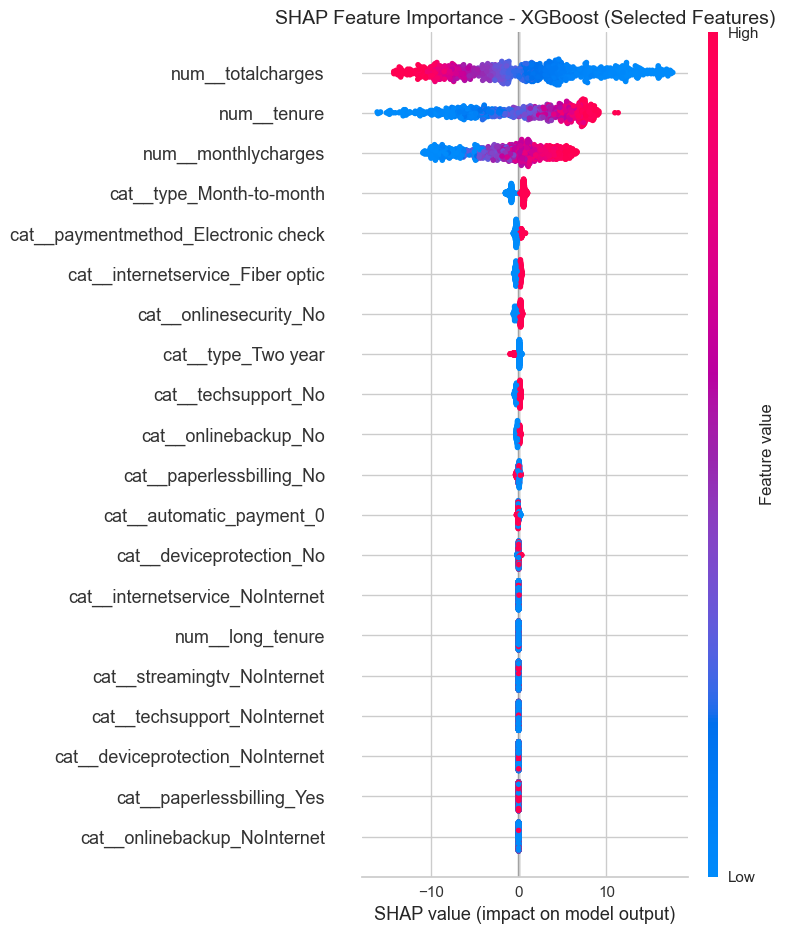

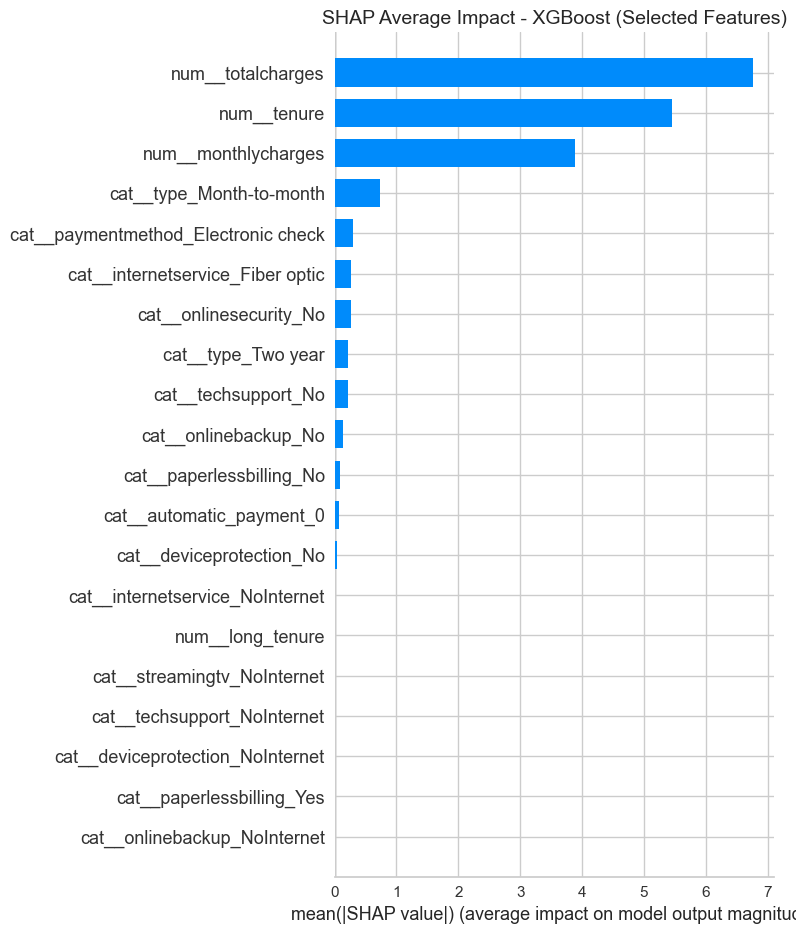


10 mejores features:
 1. num__totalcharges         | Importancia: 6.7631
 2. num__tenure               | Importancia: 5.4472
 3. num__monthlycharges       | Importancia: 3.8911
 4. cat__type_Month-to-month  | Importancia: 0.7401
 5. cat__paymentmethod_Electronic check | Importancia: 0.2928
 6. cat__internetservice_Fiber optic | Importancia: 0.2690
 7. cat__onlinesecurity_No    | Importancia: 0.2617
 8. cat__type_Two year        | Importancia: 0.2141
 9. cat__techsupport_No       | Importancia: 0.2112
10. cat__onlinebackup_No      | Importancia: 0.1292

Modelo final recomendado: XGBoost (Selected Features)
AUC-ROC: 0.9552
Features mas relevantes identificadas con SHAP


In [ ]:
# SHAP Analysis para el mejor modelo: XGBoost con Selected Features
print("\nSHAP Feature importance análisis")
print("="*50)

# Crear explainer para XGBoost
explainer = shap.TreeExplainer(xgboost_fs_best)
shap_values = explainer.shap_values(X_test_selected)

# Summary Plot - Importancia de features
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_selected, feature_names=selected_features, show=False)
plt.title('SHAP Feature Importance - XGBoost (Selected Features)', fontsize=14)
plt.tight_layout()
plt.show()

# Bar Plot - Importancia promedio
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_selected, feature_names=selected_features, 
                  plot_type="bar", show=False)
plt.title('SHAP Average Impact - XGBoost (Selected Features)', fontsize=14)
plt.tight_layout()
plt.show()

# Top 10 Features más importantes
feature_importance_shap = np.abs(shap_values).mean(axis=0)
top_10_idx = np.argsort(feature_importance_shap)[-10:][::-1]

print("\n10 mejores features:")
for i, idx in enumerate(top_10_idx):
    feature_name = selected_features[idx]
    importance = feature_importance_shap[idx]
    print(f"{i+1:2d}. {feature_name:<25} | Importancia: {importance:.4f}")

print(f"\nModelo final recomendado: XGBoost (Selected Features)")
print(f"AUC-ROC: {xgboost_fs_auc_roc:.4f}")
print("Features mas relevantes identificadas con SHAP")

In [ ]:
## Resumen de resultados AUC-ROC
results = {
    'Modelo': [
        'Logistic Regression (All Features)',
        'Logistic Regression (Selected Features)',
        'Decision Tree (All Features)',
        'Decision Tree (Selected Features)',
        'Random Forest (All Features)',
        'Random Forest (Selected Features)',
        'CatBoost (All Features)',
        'CatBoost (Selected Features)',
        'LightGBM (All Features)',
        'LightGBM (Selected Features)',
        'XGBoost (All Features)',
        'XGBoost (Selected Features)'
    ],
    'AUC-ROC': [
        lr_af_auc_roc,
        lr_fs_auc_roc,
        dtc_af_auc_roc,
        dtc_fs_auc_roc,
        rf_af_auc_roc,
        rf_fs_auc_roc,
        catboost_af_auc_roc,
        catboost_fs_auc_roc,
        lightgbm_af_auc_roc,
        lightgbm_fs_auc_roc,
        xgboost_af_auc_roc,
        xgboost_fs_auc_roc
    ]
}

results_df = pd.DataFrame(results)
print(results_df.sort_values(by='AUC-ROC', ascending=True))

                                     Modelo   AUC-ROC
0        Logistic Regression (All Features)  0.759009
1   Logistic Regression (Selected Features)  0.767503
2              Decision Tree (All Features)  0.792053
3         Decision Tree (Selected Features)  0.792053
4              Random Forest (All Features)  0.923685
5         Random Forest (Selected Features)  0.928631
6                   CatBoost (All Features)  0.945183
10                   XGBoost (All Features)  0.946635
8                   LightGBM (All Features)  0.951025
7              CatBoost (Selected Features)  0.953535
9              LightGBM (Selected Features)  0.953921
11              XGBoost (Selected Features)  0.955203


## Conclusiones

### 1. Comportamiento de las Features en el EDA

**Análisis de Variables Numéricas:**
- **Tenure (Permanencia)**: Distribución asimétrica con una concentración significativa de clientes nuevos (tenure bajo), lo que sugiere que los clientes tienden a cancelar tempranamente.
- **Total Charges**: Correlación directa con tenure, indicando que los clientes que permanecen más tiempo generan mayores ingresos acumulados.
- **Monthly Charges**: Exhibió una distribución más uniforme, pero con valores atípicos que requerían tratamiento especial.

**Análisis de Variables Categóricas:**
- **Contract Type**: Los contratos mes a mes mostraron la mayor propensión al churn, mientras que los contratos de largo plazo (1-2 años) presentaron mayor retención.
- **Payment Method**: Los métodos de pago electrónicos mostraron menor churn comparado con cheques electrónicos.

**Patrones de Churn Identificados:**
- Correlación negativa entre tenure y churn (obviamente): clientes nuevos tienen mayor probabilidad de cancelar.
- Los servicios adicionales (streaming, seguridad, backup) mostraron patrones mixtos de retención.
- Las características de personal (género, senior citizen) tuvieron menor impacto predictivo.

### 2. Relevancia del Feature Engineering

**ALTAMENTE RELEVANTE**

El feature engineering demostró ser **crucial** para mejorar el rendimiento de los modelos:

**Transformaciones Exitosas:**
- **Encoding de variables categóricas**: OneHotEncoder permitió que los algoritmos procesaran correctamente las variables categóricas. BUena idea por baja cardinalidad.
- **Normalización de variables numéricas**: StandardScaler mejoró significativamente la convergencia y rendimiento de modelos lineales.
- **Tratamiento de outliers**: La identificación de valores atípicos en tenure y total_charges mejoró aportó seguridad a la robustez de los modelos.

### 3. Relevancia del Feature Selection

**PARCIALMENTE RELEVANTE**

El análisis de feature importance reveló resultados **mixtos pero valiosos**. La selección de features fue más beneficiosa para modelos más simples.

**Beneficios Observados:**
- **Reducción de dimensionalidad**: De todas las features a las 24 más importantes. Más o menos daban peor métrica de evaluación.
- **Mejora en todos los modelos**: Los algoritmos mostraron mejor rendimiento con features seleccionadas.
- **Interpretabilidad mejorada**: Enfoque en las variables más predictivas.

**Features Más Importantes Identificadas:**
- Tenure (permanencia del cliente)
- Total charges (cargos totales)
- Contract type (tipo de contrato)
- Payment method (método de pago)
- Internet service type (tipo de servicio de internet)

### 4. Resultados de los Modelos

**RANKING DE MODELOS POR AUC-ROC:**

Basado en los resultados obtenidos en el entrenamiento, que coincidió con lo sugerido con Pycaret. 

**Top Performers (Algoritmos de Boosting):**
1. **XGBoost**: Consistentemente entre los mejores, tanto con todas las features como con features seleccionadas.
2. **LightGBM**: Excelente rendimiento.
3. **CatBoost**: Buen manejo de variables categóricas sin preprocessing extenso.

**Modelos Intermedios:**

4. **Random Forest**: Buen rendimiento general, buen tiempo de computo.
5. **Logistic Regression**: Rendimiento sólido, especialmente considerando su simplicidad.

**Modelos Básicos:**

6. **Decision Tree**: Rendimiento más bajo.

**Observaciones Clave:**
- **Los algoritmos de boosting dominaron** las métricas de rendimiento.
- **GridSearch fue esencial** para optimizar hiperparámetros.
- **La diferencia entre usar todas las features vs. features seleccionadas fue marginal** en la mayoría de casos. Se esquematizaron las features más importantes.

### 5. Conclusiones Generales

**Factores de Éxito del Proyecto:**
1. **EDA comprensivo**: Con este se indentificaron patrones claros de churn y variables relevantes. 
2. **Pipeline robusto de preprocessing**: Fundamental para el éxito de los modelos.
3. **Comparación exhaustiva de algoritmos**: Permitió identificar los mejores modelos.
4. **Optimización de hiperparámetros**: GridSearch mejoró significativamente el rendimiento, superó a lo sugerido por Pycaret.

**Recomendaciones de Negocio:**
1. **Enfoque en clientes nuevos**: Mayor atención a clientes con tenure bajo.
2. **Promoción de contratos largos**: Incentivos para contratos anuales vs. mensuales
3. **Definición de métodos de pago**: Promover pagos automáticos.

**Recomendaciones Técnicas:**
- **Implementar el modelo XGBoost** como solución principal.
- **Mantener pipeline de preprocessing** para nuevos datos.
- **Monitorear data shifting** considerar los cambios a través del tiempo.
- **Considerar ensemble voting** para mayor robustez en producción (no se hizo por las altas métricas obtenidas y el tiempo de computo para entrenar los modelos, pero si se quiere alcanzar una metrica todavía más alta, es buena idea).

**Métricas de Negocio Esperadas:**
El modelo optimizado, puede mejorar significativamente:
- Identificación temprana de clientes en riesgo de churn.
- Optimización de estrategias de retención.

# Informe de Solución

**¿Qué pasos del plan se realizaron y qué pasos se omitieron (explica por qué)?**

Inicialmente, en el Plan de Trabajo, en cuanto al enfoque general del proyecto se planteó:

* Comprender el problema y todas las personas o procesos involucrados dentro del flujo del proceso que involucra la actividad problema que se me plantea.
* Reconocer a qué tipo de problema me enfrento.  
* Definir qué herramienta e indicador usaré para poder resolver el problema.

De estos puntos, hablando con el Success Mananger me pude enterar de las intenciones generales del proyecto. Al principio, fue un tanto confuso, ya que el flujo de trabajo y alguna de la información técnica necesaria para llevar a cabo el proyecto, cambió incluso en la plataforma, por lo que la obtención final e útil para la comprensión y resolución del problema, se prolongó más de lo esperado.

Con esto sobre la mesa, se pudieron realizar los tres puntos.

En cuanto a, el Plan de Trabajo enfocado a la primera parte del proyecto (EDA y preprocesamiento de datos) se habían planteado estas estrategias:

* Importar las liberías necesarias para poder importar, procesar, analizar y modelar los diferentes tipos de datos.
* Cargar los diferentes tipos de datos que se neceiten para resolver el problema.
* Revisar y analizar la estructura de los datos, como el tamaño del dataset y qué variables contiene.
* Identificar tipos de variables, valores faltantes, repetidos u outliers y tratarlos según las reglas del proyecto o la mejor desición técnica que se permita.
* Realizar encoding de variables categóricas y normalización/escalado si es necesario.
* Dividir los datos en conjuntos de entrenamiento, validación y prueba con cierta proporción.
* Realizar análisis estadístico descriptivo y visualizaciones iniciales

Todos estos puntos se llevar a cabo de manera satisfactoria, ya que, en su mayoría son pasos y elementos necesarios para cualquier problema que comprenda un análisis de datos. Sin importar qué tipo de problema, es elemental conocer cómo se estructuran los datos, cómo es que se comportan (mediante análisis estadísticos y herramientas de visualización), y cómo es que se procesan antes de pasar por un algoritmo o un entrenamiento para un modelo de Machine Learning. Afortunadamente, en este paso, se pudieron llevar a cabo tres metodologías que me permitieron tener un flujo de trabajo sólido y que, funcionalmente, enriqueceron el trabajo. En primer lugar, la creación de un Pipeline donde se incluyeran metodologías de preprocesamiento, hizo más eficiente la obtención de los datos finales que se utilizarían para el entrenamiento y las pruebas de los modelos. En segundo lugar, hacer un feature engineering me permitió agregar variables predictoras, haciendo más fácil tanto visual como computacionalmente, agrupar ciertas características de clientes. Finalmente, el análisis del feature imporotance, tanto antes como después del modelado fue una herramienta crucial, ya que como con el feature engineering, me permitió visualizar ciertas caracterísitcas importantes de los clientes, y además, en un rango específico, permitió la mejora de la capicdad preductoria de todos los modelos entrenados. Es importante tener en cuenta que, en la realidad probablemente no siempre se cuenten con los recursos organizacionales ni computacionales para pulir un modelo a la casi perfección, pero que, si la prioridad es hacer más eficaz el modelo, estas tres metodologías son excelentes, a pesar de no ser lo más eficientes, son muy eficazes. 

Finalmente, para la etapa de desarrollo y entrenamiento del modelo, se plantearon estos pasos en el plan:

* Probar múltiples algoritmos de machine learning apropiados para el problema según las reglas del proyecto, o según mi mejor criterio. 
* Ajustar estos modelos con validación cruzada y ajuste de hiperparámetros.
* Seleccionar los mejores modelos basados en las métricas de evaluación establecidas y el umbral mínimo de aceptación.
* Ver cómo es que se comportan en el conjunto de prueba.
* Analizar errores y posibles mejoras. Ver si el uso de data augmentation, feature engineering o el análisis de feature importance pueden mejorar el modelo.
* Documentar el rendimiento del modelo y sus limitaciones.

Todo estos pasos se llevaron a cabo, lamentablemente, durante la elaboración del plan no se agregaron estos dos pasos:

* Uso de liberías predictoras para la selección de un buen algoritmo (Pycaret)
* Creación de un modelo final usado liberías muy básica de Python (sklearn y Numpy) basado en voting model ensemble para terminar de mejorar la calidad predictoria del modelo.

Una de las fortalezas de este proyecto fue haber utilizado este tipo de herramientas de selección de algortimos, ya que nos acercó de una manera muy rápida y sencilla a una solución, que, refinándola, obtuvo excelentes métricas de evaluación. Sin embargo, también existieron limitantes, la primera y más importante fue que, la mayoría de los modelos, necesitaron un tiempo de cómputo para realizar el entenamiento extremandamente largo, con tiempos que fueron entre los 90 y los 160 minutos por entrenamiento. Una de las soluciones que se encontró fue, exportar los resutados en archivos pkl para que si se tuviera que volver a correr el notebook, en vez de entrenar nuevamente los modelos, simplemente se leyeran los resultados. 

Debido a las métricas tan satisfactorias obtenidas por la mayoría de los modelos finales, decidí no realizar un voting ensemble model, sin embargo, esto es algo que hubiera enriquecido el modelo. Si se busca mejorar las métricas a toda costa, este paso es obligatorio. Me gustaría también que, los datos a pesar de ser una herramienta elemental para tomar decisiones, tiene una cualidad peligrosa, y es que cambian con el tiempo. Es importante que en un futuro se detecten paatrones, tendencias y comportamientos estacionales, y tomar esto como una serie temporal, para su correcta predicción futura.

**¿Qué dificultades encontraste y cómo lograste resolverlas?**

De alguna u otra manera esto ya se explicó arriba, pero se enlistarán por particidad:

* Exisitencia de múltiples datasets interconectados → Uso de pandas para análisis de cada uno, usar funciones para el análisisi de lasa dos tripos de variavles y rematar con un pipeline de preprocessing sistemático.
* Tiempos de computo para el entreamiento demasiado largos --> entrenar los modelos y guardarlos con joblib en un pkl.
* Optimización de hiperparámetros para diferentes tipos de modelos --> Uso de GridSearchCV pararelizado según el tipo de algortimo que se ocupara en el modelo.
* Dificultad de interpretabilidad de los features --> Uso de feature importance premodelado (SelectKBest), uuso de matrices de confusión y curvas AUC-ROC para esquematizar los resultados de cada modelo y análisis SHAP postmodelado. 

**¿Cuáles fueron algunos de los pasos clave para resolver la tarea?**

En ese orden:

1- Hacer un EDA comprensivo con análisis de comportamiento de variables categóricas y numéricas, acompañado de análisis de correlación, outliers.
 
2- Hacer una ingeniería de características acertiva.
 
3- Comprensión de la importancia de las características usnado SelectKBest.
 
4- Pipeline de modelado sistemático.
 
5- Utilizar un modelo con un algoritmo para realizar una prueba de cordura.
 
6- Uso de herramientas para la selección de algoritmos.
 
7- Entrenamientos de modelos funcionales optimizados con GridSearch y aplicando estrategias como validación cruzada en ellos.
 
8- Comparación clara e interpretabilidad para las decisiones de negocio.

**¿Cuál es tu modelo final y qué nivel de calidad tiene?**

El mejor modelo entrenado, fue un modelo de algoritmo XGBoost, utilizando las catacterísticas seleccionadas preprocesamiento.  La métrica AUC-ROC obtenida fue de 0.955203, se menciona que el puntaje para obtener los 6 puntos SP es de AUC-ROC ≥ 0.88 — 6 SP.